# House Price Prediction using Advanced Regression Methods

# Content

    1. Data Screening
        1.1 Discret Columns
        1.2 Continuous Columns
        1.3 Visualizations
            1.3.1 Date Features
            1.3.2 Size Features
            1.3.3 Room Features
            1.3.4 Quality And Condition Features
            1.3.5 Material Features
            1.3.6 Other Categorical Features
            1.3.7 Other General Features
            1.3.8 General Plots
    2. Data Preparation
        2.1 Cleaning Functions
        2.2 Cleaning Functions Test
        2.3 Pipeline Functions
    3. Simple Model
        3.1 Fist Submission
    4. Feature Engineering And Pipeline Extension
        4.1 Test Additional Features And New Pipeline Functions
        4.2 New Pipeline
    5. Modeling Selection 

### Importing libraries 

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import warnings
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, KFold, cross_val_score
# import optuna
from sklearn.preprocessing import QuantileTransformer
warnings.filterwarnings(action='ignore', category=UserWarning) 

# 1. Data Screening 👀🔎📊
There are a lot of features, so let's create a DataFrame that contains the needed information about each column for later use.

In [2]:
# loading data 
train_df = pd.read_csv('train.csv')      # one addition column is target varible i.e. SalePrice
test_df = pd.read_csv('test.csv');
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [3]:
combined_df= pd.concat([train_df, test_df]);
combined_df.shape

(2919, 81)

In [4]:
combined_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000.0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000.0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000.0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000.0


In [5]:
column_informations = {}
num_values = len(train_df)
for col in train_df.columns:
    num_unique = train_df[col].nunique()
    num_nulls = round(train_df[col].isna().sum()/num_values,2)
    d_type = train_df.dtypes[col]
    
    if (num_unique < 30):
        # discrete column
        info_str = "["
        value_counts = train_df[col].value_counts()
        single_value_weight = round(value_counts.iloc[0] / num_values, 2)
        for index, value in value_counts.items():
            info_str += f"{value} X {index}, "
        column_informations[col] = {"d_type":d_type, "discret": True, "percentage_of_missing_values": num_nulls, "single_value_weight": single_value_weight,
                                    "min": 0.0, "max": 0.0, "mean": 0.0, "median": 0.0, "info_str": info_str[:-2] + "]"} 
    else:
        # continuous column
        if d_type == "int64" or d_type == "float64":
            column_informations[col] = {"d_type":d_type, "discret": False, "percentage_of_missing_values": num_nulls, "single_value_weight": 0.0,
                                        "min": train_df[col].min(), "max": train_df[col].max(), "mean": round(train_df[col].mean(), 2),
                                        "median": round(train_df[col].median(), 2), "info_str": ""}
        else:
            column_informations[col] = {"d_type":d_type, "discret": False, "percentage_of_missing_values": num_nulls, "min": "-", "max": "-",
                                        "mean": "-", "median": "-", "info_str": ""}

# build DataFrame from dictionary
info_df = pd.DataFrame.from_dict(column_informations, orient='index')



In [6]:
info_df

,d_type,discret,percentage_of_missing_values,single_value_weight,min,max,mean,median,info_str
Id,int64,False,0.00,0.00,1.0,1460.0,730.50,730.5,
MSSubClass,int64,True,0.00,0.37,0.0,0.0,0.00,0.0,"[536 X 20, 299 X 60, 144 X 50, 87 X 120, 69 X ..."
MSZoning,object,True,0.00,0.79,0.0,0.0,0.00,0.0,"[1151 X RL, 218 X RM, 65 X FV, 16 X RH, 10 X C..."
LotFrontage,float64,False,0.18,0.00,21.0,313.0,70.05,69.0,
LotArea,int64,False,0.00,0.00,1300.0,215245.0,10516.83,9478.5,
...,...,...,...,...,...,...,...,...,...
MoSold,int64,True,0.00,0.17,0.0,0.0,0.00,0.0,"[253 X 6, 234 X 7, 204 X 5, 141 X 4, 122 X 8, ..."
YrSold,int64,True,0.00,0.23,0.0,0.0,0.00,0.0,"[338 X 2009, 329 X 2007, 314 X 2006, 304 X 200..."
SaleType,object,True,0.00,0.87,0.0,0.0,0.00,0.0,"[1267 X WD, 122 X New, 43 X COD, 9 X ConLD, 5 ..."
SaleCondition,object,True,0.00,0.82,0.0,0.0,0.00,0.0,"[1198 X Normal, 125 X Partial, 101 X Abnorml, ..."


## 1.1 Discret Columns: 

In [7]:
display(HTML(info_df[info_df["discret"]==True][["d_type", "percentage_of_missing_values", "single_value_weight", "info_str"]].to_html()))
print(len(info_df[info_df["discret"]==True]))

,d_type,percentage_of_missing_values,single_value_weight,info_str
MSSubClass,int64,0.00,0.37,"[536 X 20, 299 X 60, 144 X 50, 87 X 120, 69 X 30, 63 X 160, 60 X 70, 58 X 80, 52 X 90, 30 X 190, 20 X 85, 16 X 75, 12 X 45, 10 X 180, 4 X 40]"
MSZoning,object,0.00,0.79,"[1151 X RL, 218 X RM, 65 X FV, 16 X RH, 10 X C (all)]"
Street,object,0.00,1.00,"[1454 X Pave, 6 X Grvl]"
Alley,object,0.94,0.03,"[50 X Grvl, 41 X Pave]"
LotShape,object,0.00,0.63,"[925 X Reg, 484 X IR1, 41 X IR2, 10 X IR3]"
LandContour,object,0.00,0.90,"[1311 X Lvl, 63 X Bnk, 50 X HLS, 36 X Low]"
Utilities,object,0.00,1.00,"[1459 X AllPub, 1 X NoSeWa]"
LotConfig,object,0.00,0.72,"[1052 X Inside, 263 X Corner, 94 X CulDSac, 47 X FR2, 4 X FR3]"
LandSlope,object,0.00,0.95,"[1382 X Gtl, 65 X Mod, 13 X Sev]"
Neighborhood,object,0.00,0.15,"[225 X NAmes, 150 X CollgCr, 113 X OldTown, 100 X Edwards, 86 X Somerst, 79 X Gilbert, 77 X NridgHt, 74 X Sawyer, 73 X NWAmes, 59 X SawyerW, 58 X BrkSide, 51 X Crawfor, 49 X Mitchel, 41 X NoRidge, 38 X Timber, 37 X IDOTRR, 28 X ClearCr, 25 X StoneBr, 25 X SWISU, 17 X MeadowV, 17 X Blmngtn, 16 X BrDale, 11 X Veenker, 9 X NPkVill, 2 X Blueste]"


61


# .

# 1.2 Continuous Columns

In [8]:
display(HTML(info_df[info_df["discret"]==False][["d_type", "percentage_of_missing_values", "min", "max", "mean", "median"]].to_html()))
print(len(info_df[info_df["discret"]==False]))

,d_type,percentage_of_missing_values,min,max,mean,median
Id,int64,0.00,1.0,1460.0,730.50,730.5
LotFrontage,float64,0.18,21.0,313.0,70.05,69.0
LotArea,int64,0.00,1300.0,215245.0,10516.83,9478.5
YearBuilt,int64,0.00,1872.0,2010.0,1971.27,1973.0
YearRemodAdd,int64,0.00,1950.0,2010.0,1984.87,1994.0
MasVnrArea,float64,0.01,0.0,1600.0,103.69,0.0
BsmtFinSF1,int64,0.00,0.0,5644.0,443.64,383.5
BsmtFinSF2,int64,0.00,0.0,1474.0,46.55,0.0
BsmtUnfSF,int64,0.00,0.0,2336.0,567.24,477.5
TotalBsmtSF,int64,0.00,0.0,6110.0,1057.43,991.5


20


# .
# 1.3 Visualizations: 📉📊📈

### So what do we have 🤔?
   1. We have 61 categorical features (i.e. they have a maximum of 30 different values).
   2. We have 20 other (continues) features (with more than 30 different values).
   3. Some of these columns could also be interpreted as categorical. For example, GarageYrBlt, YearRemodAdd, or YearBuilt.
      A considerable number of categorical features have a single value weight of more than 80%, which means that more than       80% of all values are the same.
   4. We need to be careful with these. We may exclude them completely.Also, we have some features with many missing             values. We will exclude those as well.
   5. Some continuous features have a median of 0 and the distance between min-max and mean may indicate a screwed               distribution for some features.


In [9]:
sns.set(rc={'axes.facecolor':"#F1FFC9",
            "figure.facecolor":"#B2C679",
            "grid.color":"#E0D3AF",
            "axes.edgecolor":"#505541",
            "axes.labelcolor":"#505541",
            "text.color":"#505541"
           }) 


sns.set_context(rc={"axes.labelsize" : 20})



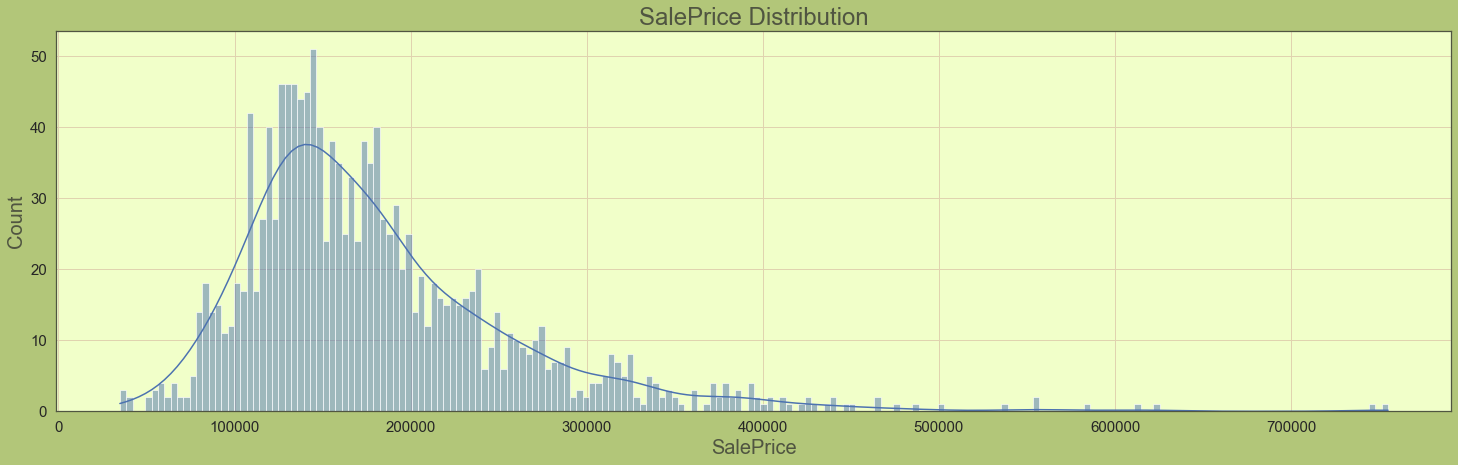

In [10]:
f, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(labelsize=15)
sns.histplot(data = train_df,x="SalePrice", kde=True, bins=200)\
            .set_title('SalePrice Distribution', fontdict= {'fontsize': 24});

As we can see, the distribution of our table is clearly left skewed. Most of the time, regression models will perform better if the distribution of the target is normally distributed. So let's use the quantile transformer for Sklearn to achieve this for our target.

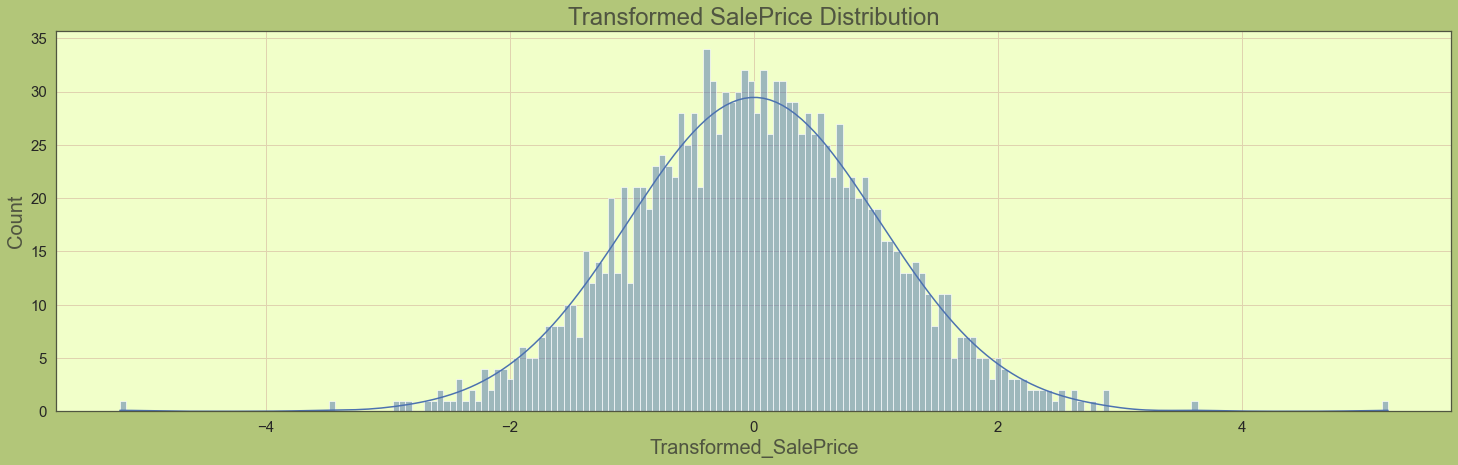

In [11]:
"""
Using quantile tranformer for transforming 
"""
qt = QuantileTransformer(random_state=0, output_distribution="normal")
target = train_df["SalePrice"].copy()
target = target.values.reshape(-1, 1)
target = qt.fit_transform(target)
target_df=pd.DataFrame(target).rename(columns={0: "Transformed_SalePrice"})

"""
That was relatively straightforward. Let's take a look at our transformed target.
"""
f, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(labelsize=15)
sns.histplot(data = target_df,x="Transformed_SalePrice", kde=True, bins=200)\
            .set_title('Transformed SalePrice Distribution', fontdict= {'fontsize': 24});

 For further visualisations it will be useful to group these prices into manageable units of equal number. We will use the "old" SalePrices for our visual groups.

In [12]:
number_of_price_groups = 5
number_of_values_per_group = len(train_df)/number_of_price_groups

visual_df = train_df.copy()
visual_df.sort_values(by=['SalePrice'], inplace=True, ignore_index=True)

"""
Get group ranges (we want the same amount of members in each group)
"""
last_boundary = 0
bounder_dict={}
for i in range(number_of_price_groups):
    boundary = visual_df.iloc[int((i+1)*number_of_values_per_group) - 1]["SalePrice"]
    bounder_dict[f"{last_boundary}-{boundary}"] = [last_boundary, boundary]
    last_boundary = boundary

def get_price_group(price, bounder_dict):
    group_lable = "-"
    for group in bounder_dict.keys():
        if bounder_dict[group][0] < price <= bounder_dict[group][1]:
            group_lable=group
    return group_lable
    
visual_df["PriceGroup"]=visual_df["SalePrice"].map(lambda x: get_price_group(x, bounder_dict));
"""
Let's check:
"""
indexs =[]
for group in visual_df["PriceGroup"].unique():
    indexs.append(visual_df[["SalePrice", "PriceGroup"]][visual_df["PriceGroup"]==group].head(1).index[0])
visual_df.loc[indexs][["SalePrice", "PriceGroup"]]

,SalePrice,PriceGroup
0,34900,0-124000
295,124500,124000-147000
589,147400,147000-179200
876,179400,179200-230000
1171,230500,230000-755000


# .
## 1.3.1 Date Features: 🔦📆

Features Explanation:
   - 1. YrSold: Year Sold (YYYY)
   - 2. MoSold: Month Sold (MM)
   - 3. GarageYrBlt: Year garage was built
   - 4. YearBuilt: Original construction date
   - 5. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [13]:
data_features = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]
info_df.loc[data_features]

,d_type,discret,percentage_of_missing_values,single_value_weight,min,max,mean,median,info_str
YearBuilt,int64,False,0.00,0.00,1872.0,2010.0,1971.27,1973.0,
YearRemodAdd,int64,False,0.00,0.00,1950.0,2010.0,1984.87,1994.0,
GarageYrBlt,float64,False,0.06,0.00,1900.0,2010.0,1978.51,1980.0,
MoSold,int64,True,0.00,0.17,0.0,0.0,0.00,0.0,"[253 X 6, 234 X 7, 204 X 5, 141 X 4, 122 X 8, ..."
YrSold,int64,True,0.00,0.23,0.0,0.0,0.00,0.0,"[338 X 2009, 329 X 2007, 314 X 2006, 304 X 200..."


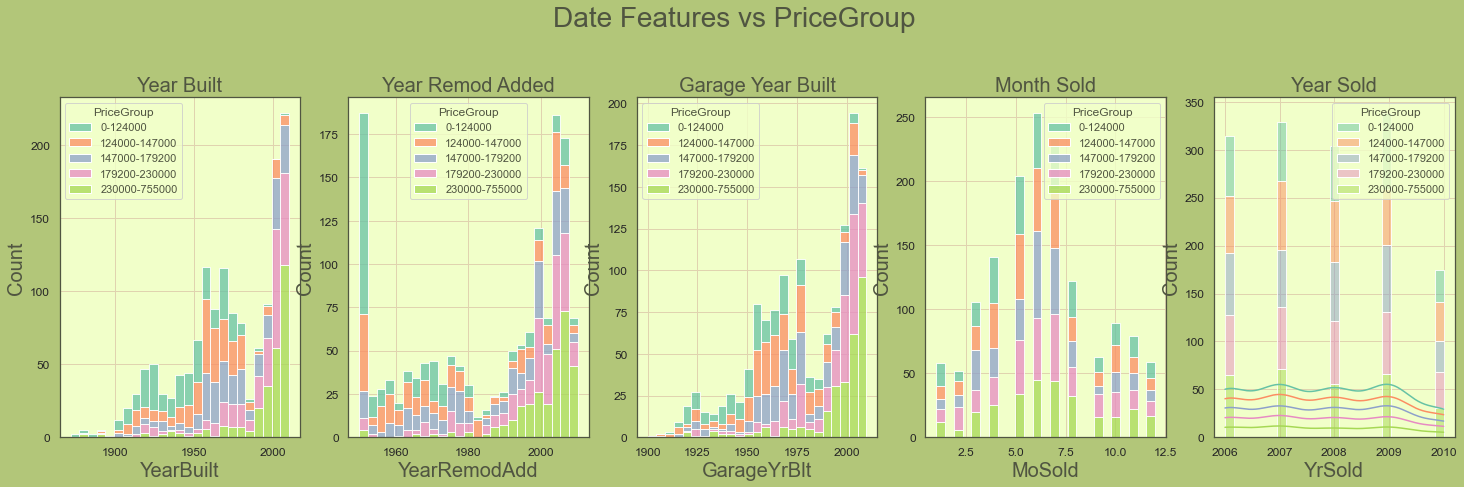

In [14]:
# build figure
fig = plt.figure(figsize=(25,7))

# add grid to figure 
gs = fig.add_gridspec(1,5)

# fill grid with subplots
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax03 = fig.add_subplot(gs[0,3])
ax04 = fig.add_subplot(gs[0,4])

# adjust subheadline fontsize
ax00.set_title('Year Built', fontsize=20)
ax01.set_title('Year Remod Added', fontsize=20)
ax02.set_title('Garage Year Built', fontsize=20)
ax03.set_title('Month Sold', fontsize=20)
ax04.set_title('Year Sold', fontsize=20)

# adjust lable fontsize
ax00.tick_params(labelsize=12)
ax01.tick_params(labelsize=12)
ax02.tick_params(labelsize=12)
ax03.tick_params(labelsize=12)
ax04.tick_params(labelsize=12)

# plot (ax=axxx is important)
sns.histplot(data = visual_df,x="YearBuilt", kde=False, ax=ax00, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="YearRemodAdd", kde=False, ax=ax01, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="GarageYrBlt", kde=False, ax=ax02, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="MoSold", kde=False, ax=ax03, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,x="YrSold", kde=True, ax=ax04, bins=25, palette="Set2", multiple="stack", hue="PriceGroup");

# add headline: (subplots_adjust must be adjusted if you change the gridspec height. So if you have more than one row of plots).
fig.subplots_adjust(top=0.8)
fig.suptitle('Date Features vs PriceGroup', fontsize="28");


We see no correlation between YrSold and PriceGroup. YearBuilt, YearRemodAdd and GarageYrBlt have the expected impact on PriceGroup.

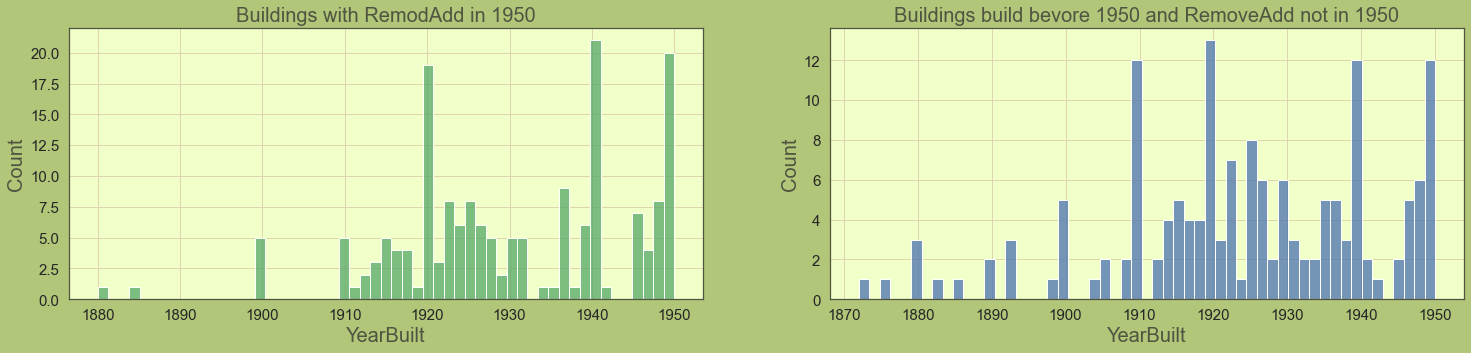

In [15]:

fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', which='major', labelsize=15)
ax01.tick_params(axis='both', which='major', labelsize=15)
ax00.set_title('Buildings with RemodAdd in 1950', fontsize=20)
ax01.set_title('Buildings build bevore 1950 and RemoveAdd not in 1950', fontsize=20)
sns.histplot(data=visual_df[visual_df["YearRemodAdd"]==1950.0], x="YearBuilt", ax=ax00, bins=55, color="g")
sns.histplot(data=visual_df[(visual_df["YearBuilt"]<=1950.0) & (visual_df["YearRemodAdd"]!=1950.0)], x="YearBuilt", ax=ax01, bins=55);

Ok, most of the buildings built before 1950 were built after 1900 and given the history between 1914 and 1945 it seems understandable that none of them were remodeled before 1950. It still seems a little odd that so many were renovated in that year and not in 1949 for example. Perhaps there was some sort of government assistance? Bevore we move on let's look at the distribution of time between YearBuild and RemoveAdd and the time between RemovedAdd and YrSold.

In [16]:
visual_df["YearsSinceRemode"] = visual_df["YrSold"] - visual_df["YearRemodAdd"]
visual_df["YearsUntilRemode"] = visual_df["YearRemodAdd"] - visual_df["YearBuilt"]

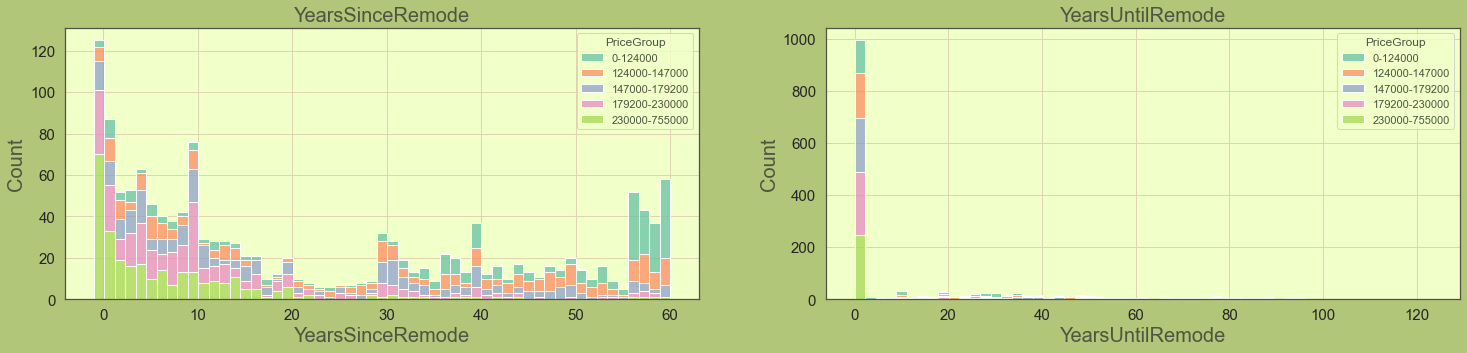

In [17]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', which='major', labelsize=15)
ax01.tick_params(axis='both', which='major', labelsize=15)
ax00.set_title('YearsSinceRemode', fontsize=20)
ax01.set_title('YearsUntilRemode', fontsize=20)
sns.histplot(data=visual_df, x="YearsSinceRemode", kde=False, ax=ax00, bins=55, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data=visual_df, x="YearsUntilRemode", kde=False, ax=ax01, bins=55, palette="Set2", multiple="stack", hue="PriceGroup");

 It looks like very few buildings have been reworked. Of course, this makes the feature much less interesting. Moreover, our new YearsSinceRemode feature is almost the same as the past time since construction.

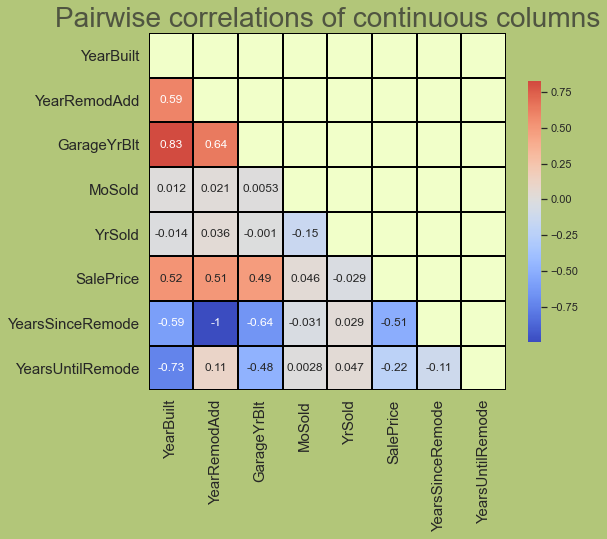

In [18]:
corr = visual_df[data_features + ["SalePrice", "YearsSinceRemode", "YearsUntilRemode"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 8))
ax.tick_params(axis='both', which='major', labelsize=15)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=1, linecolor="black", annot=True, 
                cbar_kws={"shrink": 0.6}).set_title('Pairwise correlations of continuous columns', fontsize="28");

We see the significant correlation between GarageYrBlt, YearBuit and YearRemodeAdd. The correlation between GarageYrBlt and YearRemodAdd is also not surprising. It is interesting to note that all three characteristics have more or less the same correlation with SalePrice. The correlation between YearsSinceRemode and YearRemodAdd is also obvious, but including this feature could make the algorithm's job easier.

### Conclusion: 📝
We have 5 different date features and we could craft some more, but the included information is nearly the same.
The resaon for that is, that YearRemodAdd and YearBuild are the same most of the time.
The same holds for YearBuilt and GarageYrBlt
We will decide later which ones to use.
Let us now turn to the characteristics describing the size of the different parts of the building.

# .
## 🛵🏘 1.3.2 Size Features: 🚙🏦

Features Explanation:
   1. General areas:
        - WoodDeckSF: Wood deck area in square feet
        - OpenPorchSF: Open porch area in square feet
        - EnclosedPorch: Enclosed porch area in square feet
        - 3SsnPorch: Three season porch area in square feet
        - ScreenPorch: Screen porch area in square feet
        - LotArea: Lot size in square feet
        - MasVnrArea: Masonry veneer area in square feet
        - GarageArea: Size of garage in square feet
        - GarageCars: Size of garage in car capacity
    
   2. Basement areas:
        - BsmtFinSF1: Type 1 finished basement in square feet
        - BsmtFinSF2: Type 2 finished basement in square feet
        - BsmtUnfSF: Unfinished square feet of basement area
        - TotalBsmtSF: Total square feet of basement area
    
   3. Living areas:
        - 1stFlrSF: First Floor square feet
        - 2ndFlrSF: Second floor square feet
        - LowQualFinSF: Low quality finished square feet (all floors)
        - GrLivArea: Above grade (ground) living area square feet


    We will remove "WoodDeckSF", "OpenPorchSF", "LowQualFinSF", "PoolArea", "BsmtFinSF2", "EnclosedPorch", "3SsnPorch" and "ScreenPorch" for now. (most values are 0)

In [19]:
size_features = ["LotArea","BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", \
                 "1stFlrSF", "2ndFlrSF", "GrLivArea", "GarageArea", "MasVnrArea", "OpenPorchSF"]
info_df.loc[size_features]

,d_type,discret,percentage_of_missing_values,single_value_weight,min,max,mean,median,info_str
LotArea,int64,False,0.00,0.0,1300.0,215245.0,10516.83,9478.5,
BsmtFinSF1,int64,False,0.00,0.0,0.0,5644.0,443.64,383.5,
BsmtUnfSF,int64,False,0.00,0.0,0.0,2336.0,567.24,477.5,
TotalBsmtSF,int64,False,0.00,0.0,0.0,6110.0,1057.43,991.5,
1stFlrSF,int64,False,0.00,0.0,334.0,4692.0,1162.63,1087.0,
2ndFlrSF,int64,False,0.00,0.0,0.0,2065.0,346.99,0.0,
GrLivArea,int64,False,0.00,0.0,334.0,5642.0,1515.46,1464.0,
GarageArea,int64,False,0.00,0.0,0.0,1418.0,472.98,480.0,
MasVnrArea,float64,False,0.01,0.0,0.0,1600.0,103.69,0.0,
OpenPorchSF,int64,False,0.00,0.0,0.0,547.0,46.66,25.0,


From the distance between min, max, medina, and mean, we can tell that most of these features contain outliers. We will exclude them for the visualizations.

<AxesSubplot:title={'center':'Area Features'}>

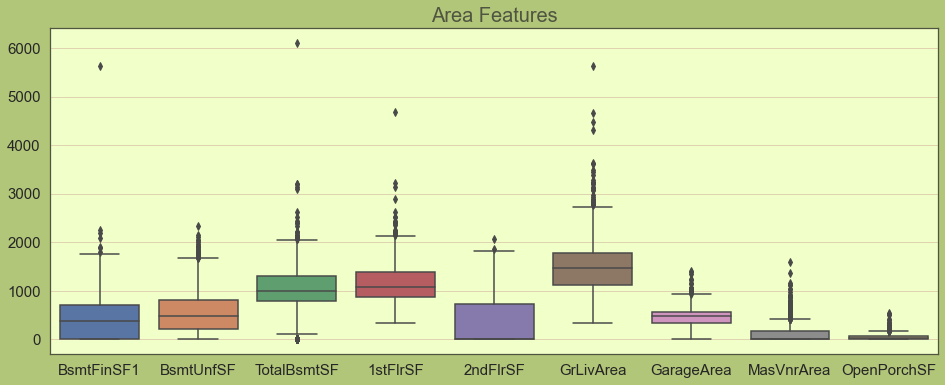

In [20]:
fig = plt.figure(figsize=(35,6))
ax00 = fig.add_subplot(gs[0,0])
ax00.set_title('Area Features', fontsize=20)
ax00.tick_params(axis='both', which='major', labelsize=15)
sns.boxplot( data=visual_df[size_features].drop('LotArea',axis=1))

<AxesSubplot:title={'center':'Lot Area Vs Price Group'}, xlabel='PriceGroup', ylabel='LotArea'>

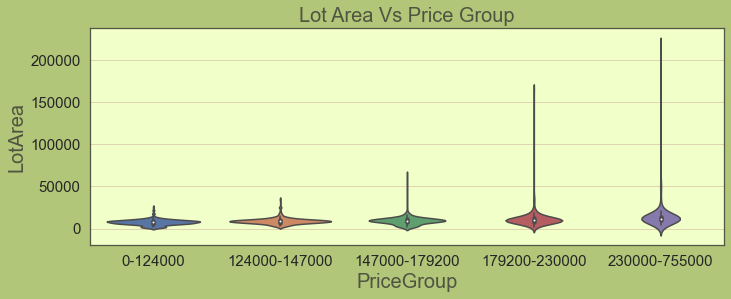

In [21]:
fig = plt.figure(figsize=(25,4))
ax00 = fig.add_subplot(gs[0,0])
ax00.set_title('Lot Area Vs Price Group', fontsize=20)
ax00.tick_params(axis='both', which='major', labelsize=15)
sns.violinplot(y = "LotArea" , x="PriceGroup", data=visual_df)

In [22]:
"""
Exclude outliers (top and bottom 10%)
"""
for feature in size_features:
    upper_quantile = visual_df[feature].quantile(0.9)
    lower_quantile = visual_df[feature].quantile(0.1)
    visual_df[feature] = np.where(visual_df[feature]>upper_quantile, upper_quantile,visual_df[feature])
    visual_df[feature] = np.where(visual_df[feature]<lower_quantile, lower_quantile,visual_df[feature])

<AxesSubplot:title={'center':'Area Features'}>

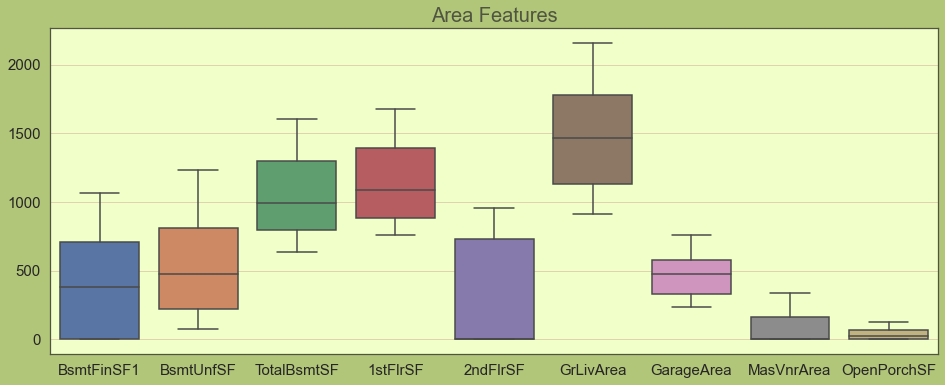

In [23]:
fig = plt.figure(figsize=(35,6))
ax00 = fig.add_subplot(gs[0,0])
ax00.set_title('Area Features', fontsize=20)
ax00.tick_params(axis='both', which='major', labelsize=15)
sns.boxplot( data=visual_df[size_features].drop('LotArea',axis=1))

<AxesSubplot:title={'center':'Lot Area Vs Price Group'}, xlabel='PriceGroup', ylabel='LotArea'>

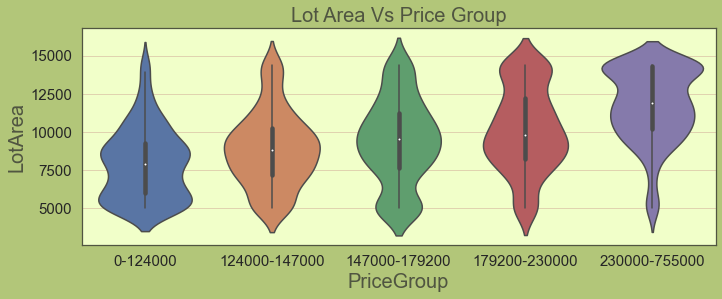

In [24]:
fig = plt.figure(figsize=(25,4))
ax00 = fig.add_subplot(gs[0,0])
ax00.set_title('Lot Area Vs Price Group', fontsize=20)
ax00.tick_params(axis='both', which='major', labelsize=15)
sns.violinplot(y = "LotArea" , x="PriceGroup", data=visual_df)

<AxesSubplot:title={'center':'Garage Cars Vs Price Group'}, xlabel='GarageCars', ylabel='count'>

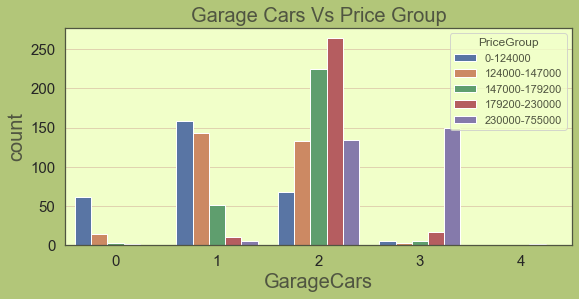

In [25]:
fig = plt.figure(figsize=(20,4))
ax00 = fig.add_subplot(gs[0,0])
ax00.set_title('Garage Cars Vs Price Group', fontsize=20)
ax00.tick_params(axis='both', which='major', labelsize=15)
sns.countplot( x="GarageCars",hue = "PriceGroup" ,data=visual_df)

GarageCars looks promesing but do we need this feature when we have GarageArea?

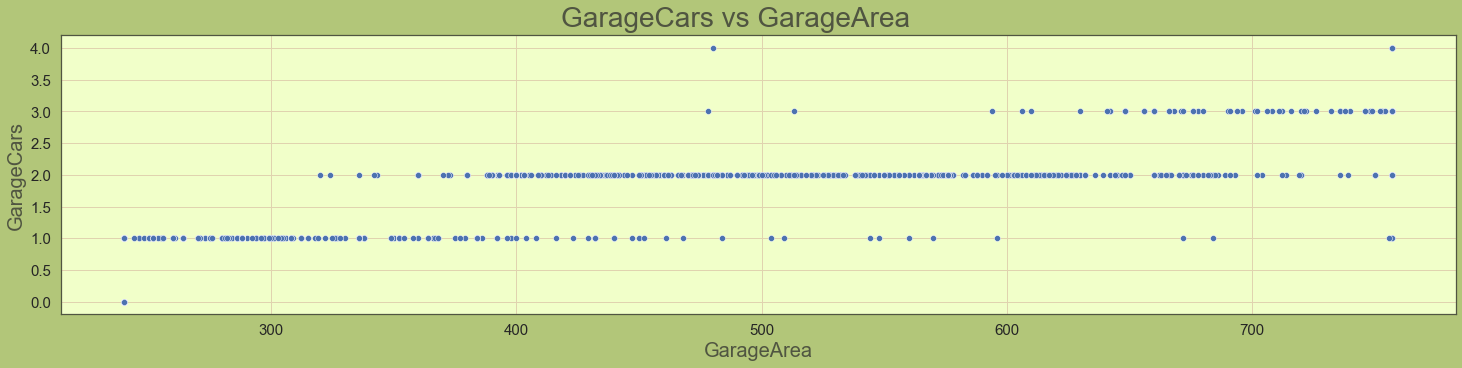

In [26]:
f, ax = plt.subplots(figsize=(25, 5))
ax.tick_params(labelsize=15)
sns.scatterplot(data=visual_df, x="GarageArea", y="GarageCars", sizes=(50, 500), palette="Paired")
f.subplots_adjust(top=0.9)
f.suptitle('GarageCars vs GarageArea', fontsize="28");

### Conclusion: 📝
   1. BsmtFinSF1, 2ndFlrSF and MasVnrArea and all excluded size features are mostly 0, because those areas are not included in all buildings.
   2. We may exclude them and create some features that indicate whether certain areas are included or not.
   3. We should keep either GaraeArea or GarageCase, not both. Maybe GarageCars is the better choice, since it is not so prone to overfitting.

Let's move on to room features.

# .
## 1.3.3 Room Features: 🛏🚽🍳
Features Explanation:
   1. BsmtFullBath: Basement full bathrooms
   2. BsmtHalfBath: Basement half bathrooms
   3. FullBath: Full bathrooms above grade
   4. HalfBath: Half baths above grade
   5. BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
   6. KitchenAbvGr: Kitchens above grade
   7. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

In [27]:
room_features= ["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd"]
info_df.loc[room_features]

,d_type,discret,percentage_of_missing_values,single_value_weight,min,max,mean,median,info_str
BsmtFullBath,int64,True,0.0,0.59,0.0,0.0,0.0,0.0,"[856 X 0, 588 X 1, 15 X 2, 1 X 3]"
BsmtHalfBath,int64,True,0.0,0.94,0.0,0.0,0.0,0.0,"[1378 X 0, 80 X 1, 2 X 2]"
FullBath,int64,True,0.0,0.53,0.0,0.0,0.0,0.0,"[768 X 2, 650 X 1, 33 X 3, 9 X 0]"
HalfBath,int64,True,0.0,0.63,0.0,0.0,0.0,0.0,"[913 X 0, 535 X 1, 12 X 2]"
BedroomAbvGr,int64,True,0.0,0.55,0.0,0.0,0.0,0.0,"[804 X 3, 358 X 2, 213 X 4, 50 X 1, 21 X 5, 7 ..."
KitchenAbvGr,int64,True,0.0,0.95,0.0,0.0,0.0,0.0,"[1392 X 1, 65 X 2, 2 X 3, 1 X 0]"
TotRmsAbvGrd,int64,True,0.0,0.28,0.0,0.0,0.0,0.0,"[402 X 6, 329 X 7, 275 X 5, 187 X 8, 97 X 4, 7..."


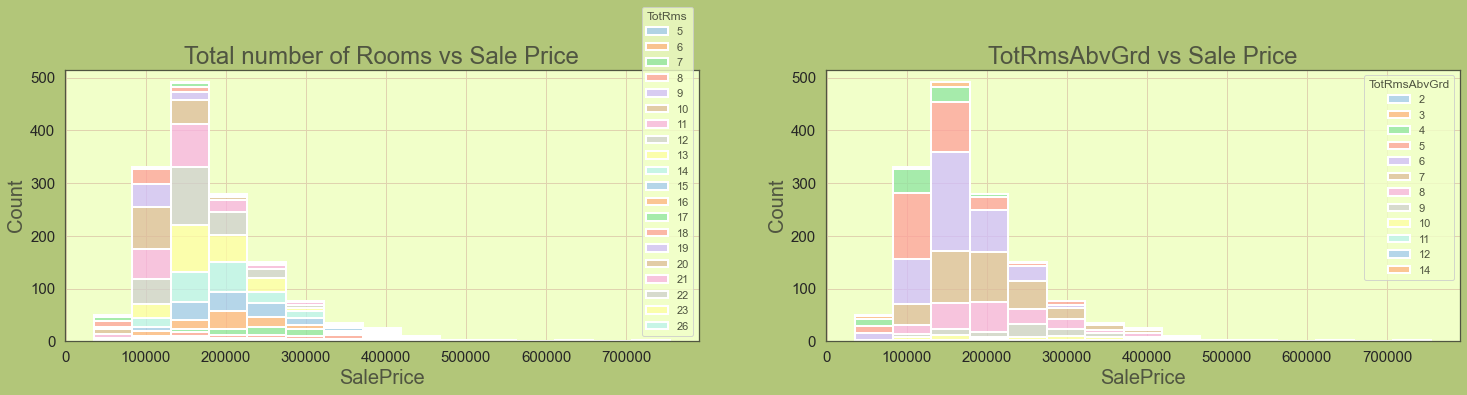

In [28]:
"""
Build total number of rooms feature:
"""
visual_df["TotRms"] = visual_df["TotRmsAbvGrd"] + visual_df["FullBath"] \
                     + visual_df["HalfBath"] + visual_df["BsmtFullBath"] + \
                    visual_df["BsmtHalfBath"] + visual_df["BedroomAbvGr"] + visual_df["KitchenAbvGr"]

fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1,2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(labelsize=15)
ax01.tick_params(labelsize=15)
sns.histplot(visual_df, hue="TotRms", x="SalePrice", bins=15, multiple="stack",ax=ax00, \
        palette="pastel", linewidth=2).set_title('Total number of Rooms vs Sale Price', fontdict= {'fontsize': 24})
sns.histplot(visual_df, hue="TotRmsAbvGrd", x="SalePrice", bins=15, multiple="stack",\
        ax=ax01, palette="pastel", linewidth=2).set_title('TotRmsAbvGrd vs Sale Price', fontdict= {'fontsize': 24});

Buildings with more rooms are more expensive and vice versa. We could take a closer look at basements and living spaces.

# .
## 1.3.4 Quality And Conditon Features:

Features Explanation:
   1. OverallQual: Rates the overall material and finish of the house
   2. OverallCond: Rates the overall condition of the house
   3. ExterQual: Evaluates the quality of the material on the exterior
   4. ExterCond: Evaluates the present condition of the material on the exterior
   5. BsmtQual: Evaluates the height of the basement
   6. BsmtCond: Evaluates the general condition of the basement
   7. BsmtFinType1: Rating of basement finished area
   8. BsmtFinType2: Rating of basement finished area (if multiple types)
   9. KitchenQual: Kitchen quality
   10. FireplaceQu: Fireplace quality
   11. GarageQual: Garage quality
   12. GarageCond: Garage condition
   13. PoolQC: Pool quality
   14. Fence: Fence quality

In [29]:
qual_and_con_features = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", \
                         "BsmtCond", "BsmtFinType1", "BsmtFinType2", "KitchenQual", "FireplaceQu", \
                         "GarageQual", "GarageCond", "PoolQC", "Fence", "HeatingQC"]
info_df.loc[qual_and_con_features][["discret", "percentage_of_missing_values", \
                                    "single_value_weight", "info_str"]]

,discret,percentage_of_missing_values,single_value_weight,info_str
OverallQual,True,0.00,0.27,"[397 X 5, 374 X 6, 319 X 7, 168 X 8, 116 X 4, ..."
OverallCond,True,0.00,0.56,"[821 X 5, 252 X 6, 205 X 7, 72 X 8, 57 X 4, 25..."
ExterQual,True,0.00,0.62,"[906 X TA, 488 X Gd, 52 X Ex, 14 X Fa]"
ExterCond,True,0.00,0.88,"[1282 X TA, 146 X Gd, 28 X Fa, 3 X Ex, 1 X Po]"
BsmtQual,True,0.03,0.44,"[649 X TA, 618 X Gd, 121 X Ex, 35 X Fa]"
BsmtCond,True,0.03,0.90,"[1311 X TA, 65 X Gd, 45 X Fa, 2 X Po]"
BsmtFinType1,True,0.03,0.29,"[430 X Unf, 418 X GLQ, 220 X ALQ, 148 X BLQ, 1..."
BsmtFinType2,True,0.03,0.86,"[1256 X Unf, 54 X Rec, 46 X LwQ, 33 X BLQ, 19 ..."
KitchenQual,True,0.00,0.50,"[735 X TA, 586 X Gd, 100 X Ex, 39 X Fa]"
FireplaceQu,True,0.47,0.26,"[380 X Gd, 313 X TA, 33 X Fa, 24 X Ex, 20 X Po]"


We will exclude all features with more then 60% single value weight und more then 80% missing values.

In [30]:
clean_qual_and_con_features = [f for f in qual_and_con_features if info_df.loc[f]["percentage_of_missing_values"] < 0.6 
                               and info_df.loc[f]["single_value_weight"] < 0.8]
print("Remaining quality and condition features:")
clean_qual_and_con_features

Remaining quality and condition features:


['OverallQual',
 'OverallCond',
 'ExterQual',
 'BsmtQual',
 'BsmtFinType1',
 'KitchenQual',
 'FireplaceQu',
 'HeatingQC']

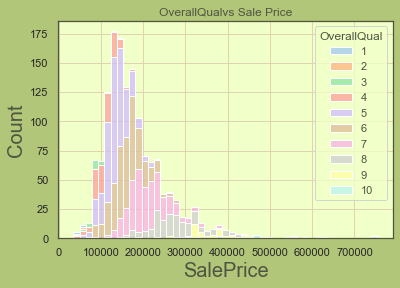

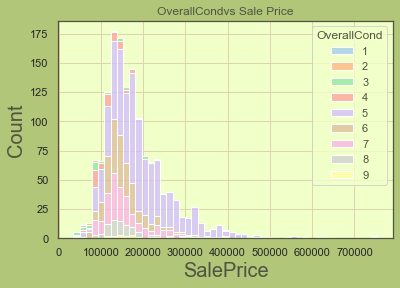

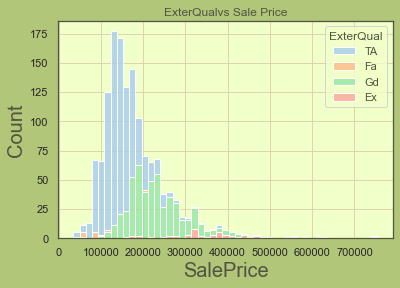

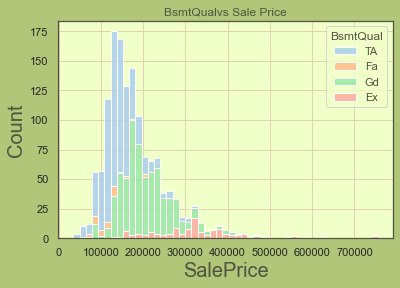

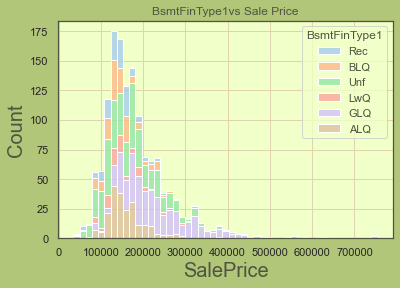

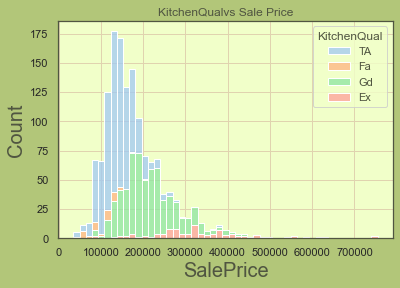

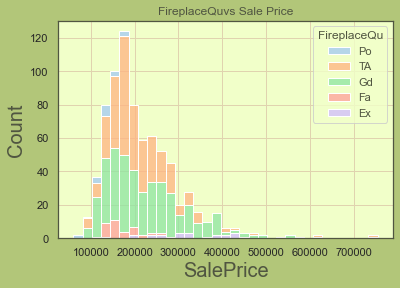

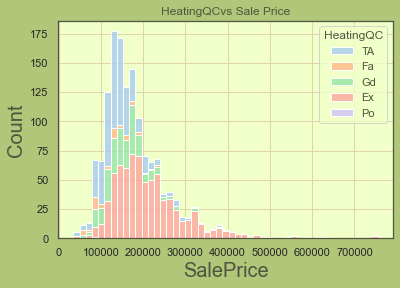

In [31]:
# clean_qual_and_con_features
for feature in clean_qual_and_con_features:
    sns.histplot(visual_df, x="SalePrice",hue = feature,  multiple="stack",\
         palette="pastel", linewidth=1).set_title(str(feature) + 'vs Sale Price')
    plt.show()

### Conclusion: 📝
- OverallQual seems to be the most important of these features.
- ExterQual, BsmtQual and KitchenQual look very similar.
- OverallCond looks counter intuitive. Maybe the way this feature is determined is not so standardized.

# .
## 1.3.5 Material Features:
Features Explanation:
1. RoofMatl: Roof material
2. Exterior1st: Exterior covering on house
3. Exterior2nd: Exterior covering on house (if more than one material)
4. MasVnrType: Masonry veneer type
5. Foundation: Type of foundation
6. PavedDrive: Paved driveway
7. GarageFinish: Interior finish of the garage

In [32]:
material_features = ["RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "PavedDrive", "BsmtFinType1", "GarageFinish"]
info_df.loc[material_features][["discret", "percentage_of_missing_values", "single_value_weight", "info_str"]]

,discret,percentage_of_missing_values,single_value_weight,info_str
RoofMatl,True,0.00,0.98,"[1434 X CompShg, 11 X Tar&Grv, 6 X WdShngl, 5 ..."
Exterior1st,True,0.00,0.35,"[515 X VinylSd, 222 X HdBoard, 220 X MetalSd, ..."
Exterior2nd,True,0.00,0.35,"[504 X VinylSd, 214 X MetalSd, 207 X HdBoard, ..."
MasVnrType,True,0.01,0.59,"[864 X None, 445 X BrkFace, 128 X Stone, 15 X ..."
Foundation,True,0.00,0.44,"[647 X PConc, 634 X CBlock, 146 X BrkTil, 24 X..."
PavedDrive,True,0.00,0.92,"[1340 X Y, 90 X N, 30 X P]"
BsmtFinType1,True,0.03,0.29,"[430 X Unf, 418 X GLQ, 220 X ALQ, 148 X BLQ, 1..."
GarageFinish,True,0.06,0.41,"[605 X Unf, 422 X RFn, 352 X Fin]"


In [33]:
"""
We exclude RoofMatl and PavedDrive due to there single value weight.
"""
clean_material_features = ["Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "BsmtFinType1", "GarageFinish"]
print("Remaining material features:")
clean_material_features

Remaining material features:


['Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtFinType1',
 'GarageFinish']

Let's see how they are distributed and what is their correlation with the selling price.

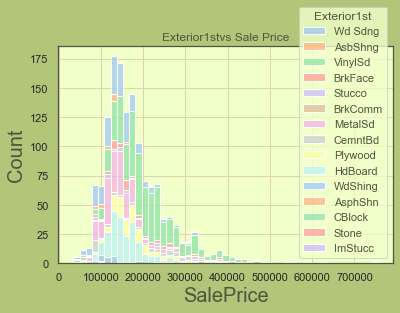

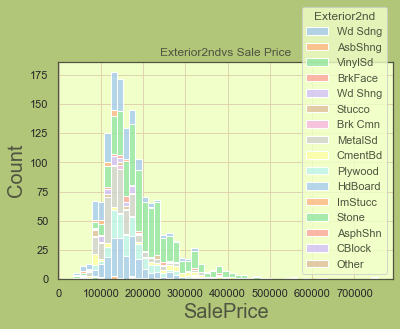

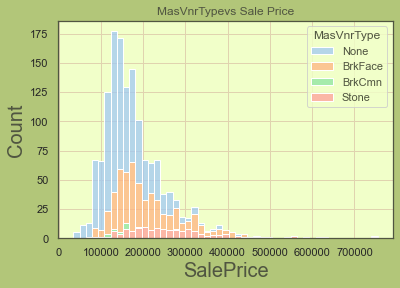

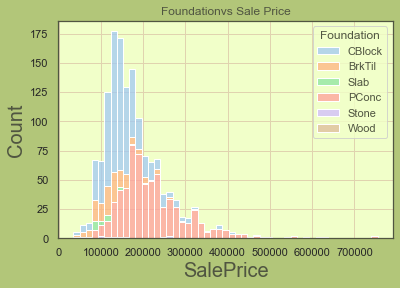

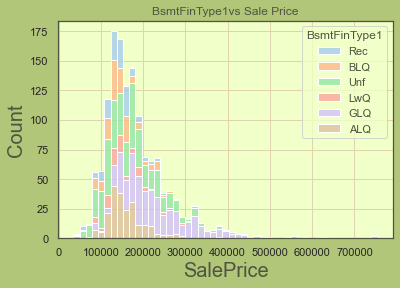

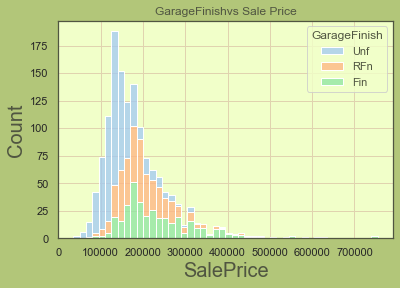

In [35]:
for feature in clean_material_features:
    sns.histplot(visual_df, x="SalePrice",hue = feature,  multiple="stack",\
         palette="pastel", linewidth=1).set_title(str(feature) + 'vs Sale Price')
    plt.show()

## Conclusion: 📝
This looks interesting. Especially Exterior1st, Exterior2nd, BsmtFinType1 and GarageFinish.
MasVnrType could be excluded for training.

# .
## 1.3.6 Other Categorical Features:
Features Explanation:
1. MSSubClass: Identifies the type of dwelling involved in the sale.
2. MSZoning: Identifies the general zoning classification of the sale.
3. LotShape: General shape of property
4. LandContour: Flatness of the property
5. Utilities: Type of utilities available
6. LotConfig: Lot configuration
7. LandSlope: Slope of property
8. Neighborhood: Physical locations within Ames city limits
9. BldgType: Type of dwelling
10. HouseStyle: Style of dwelling
11. RoofStyle: Type of roof
12. Heating: Type of heating
13. Electrical: Electrical system
14. Functional: Home functionality (Assume typical unless deductions are warranted)
15. GarageType: Garage location
16. MiscFeature: Miscellaneous feature not covered in other categories
17. SaleCondition: Condition of sale
18. PavedDrive: Paved driveway
19. CentralAir: Central air conditioning

In [36]:
other_categorical_features = ["MSSubClass", "MSZoning", "LotShape", "LandContour", "Utilities", \
                              "LotConfig", "LandSlope", "Neighborhood", "BldgType", "HouseStyle", \
                              "RoofStyle", "Heating", "Electrical", "Functional", "GarageType", \
                              "MiscFeature", "SaleCondition", "PavedDrive", "CentralAir"]
info_df.loc[other_categorical_features][["discret", "percentage_of_missing_values", \
                                         "single_value_weight", "info_str"]]

,discret,percentage_of_missing_values,single_value_weight,info_str
MSSubClass,True,0.00,0.37,"[536 X 20, 299 X 60, 144 X 50, 87 X 120, 69 X ..."
MSZoning,True,0.00,0.79,"[1151 X RL, 218 X RM, 65 X FV, 16 X RH, 10 X C..."
LotShape,True,0.00,0.63,"[925 X Reg, 484 X IR1, 41 X IR2, 10 X IR3]"
LandContour,True,0.00,0.90,"[1311 X Lvl, 63 X Bnk, 50 X HLS, 36 X Low]"
Utilities,True,0.00,1.00,"[1459 X AllPub, 1 X NoSeWa]"
LotConfig,True,0.00,0.72,"[1052 X Inside, 263 X Corner, 94 X CulDSac, 47..."
LandSlope,True,0.00,0.95,"[1382 X Gtl, 65 X Mod, 13 X Sev]"
Neighborhood,True,0.00,0.15,"[225 X NAmes, 150 X CollgCr, 113 X OldTown, 10..."
BldgType,True,0.00,0.84,"[1220 X 1Fam, 114 X TwnhsE, 52 X Duplex, 43 X ..."
HouseStyle,True,0.00,0.50,"[726 X 1Story, 445 X 2Story, 154 X 1.5Fin, 65 ..."


In [37]:
"""
Again we will exclude all features with more then 80% single value weight und more then 60% missing values.
"""
clean_other_categorical_features = [f for f in other_categorical_features if info_df.loc[f]["percentage_of_missing_values"] < 0.6 
                               and info_df.loc[f]["single_value_weight"] < 0.8]
print("Remaining other categorical features:")
clean_other_categorical_features

Remaining other categorical features:


['MSSubClass',
 'MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'GarageType']

<AxesSubplot:title={'center':'GarageType Vs Price Group'}, xlabel='count', ylabel='GarageType'>

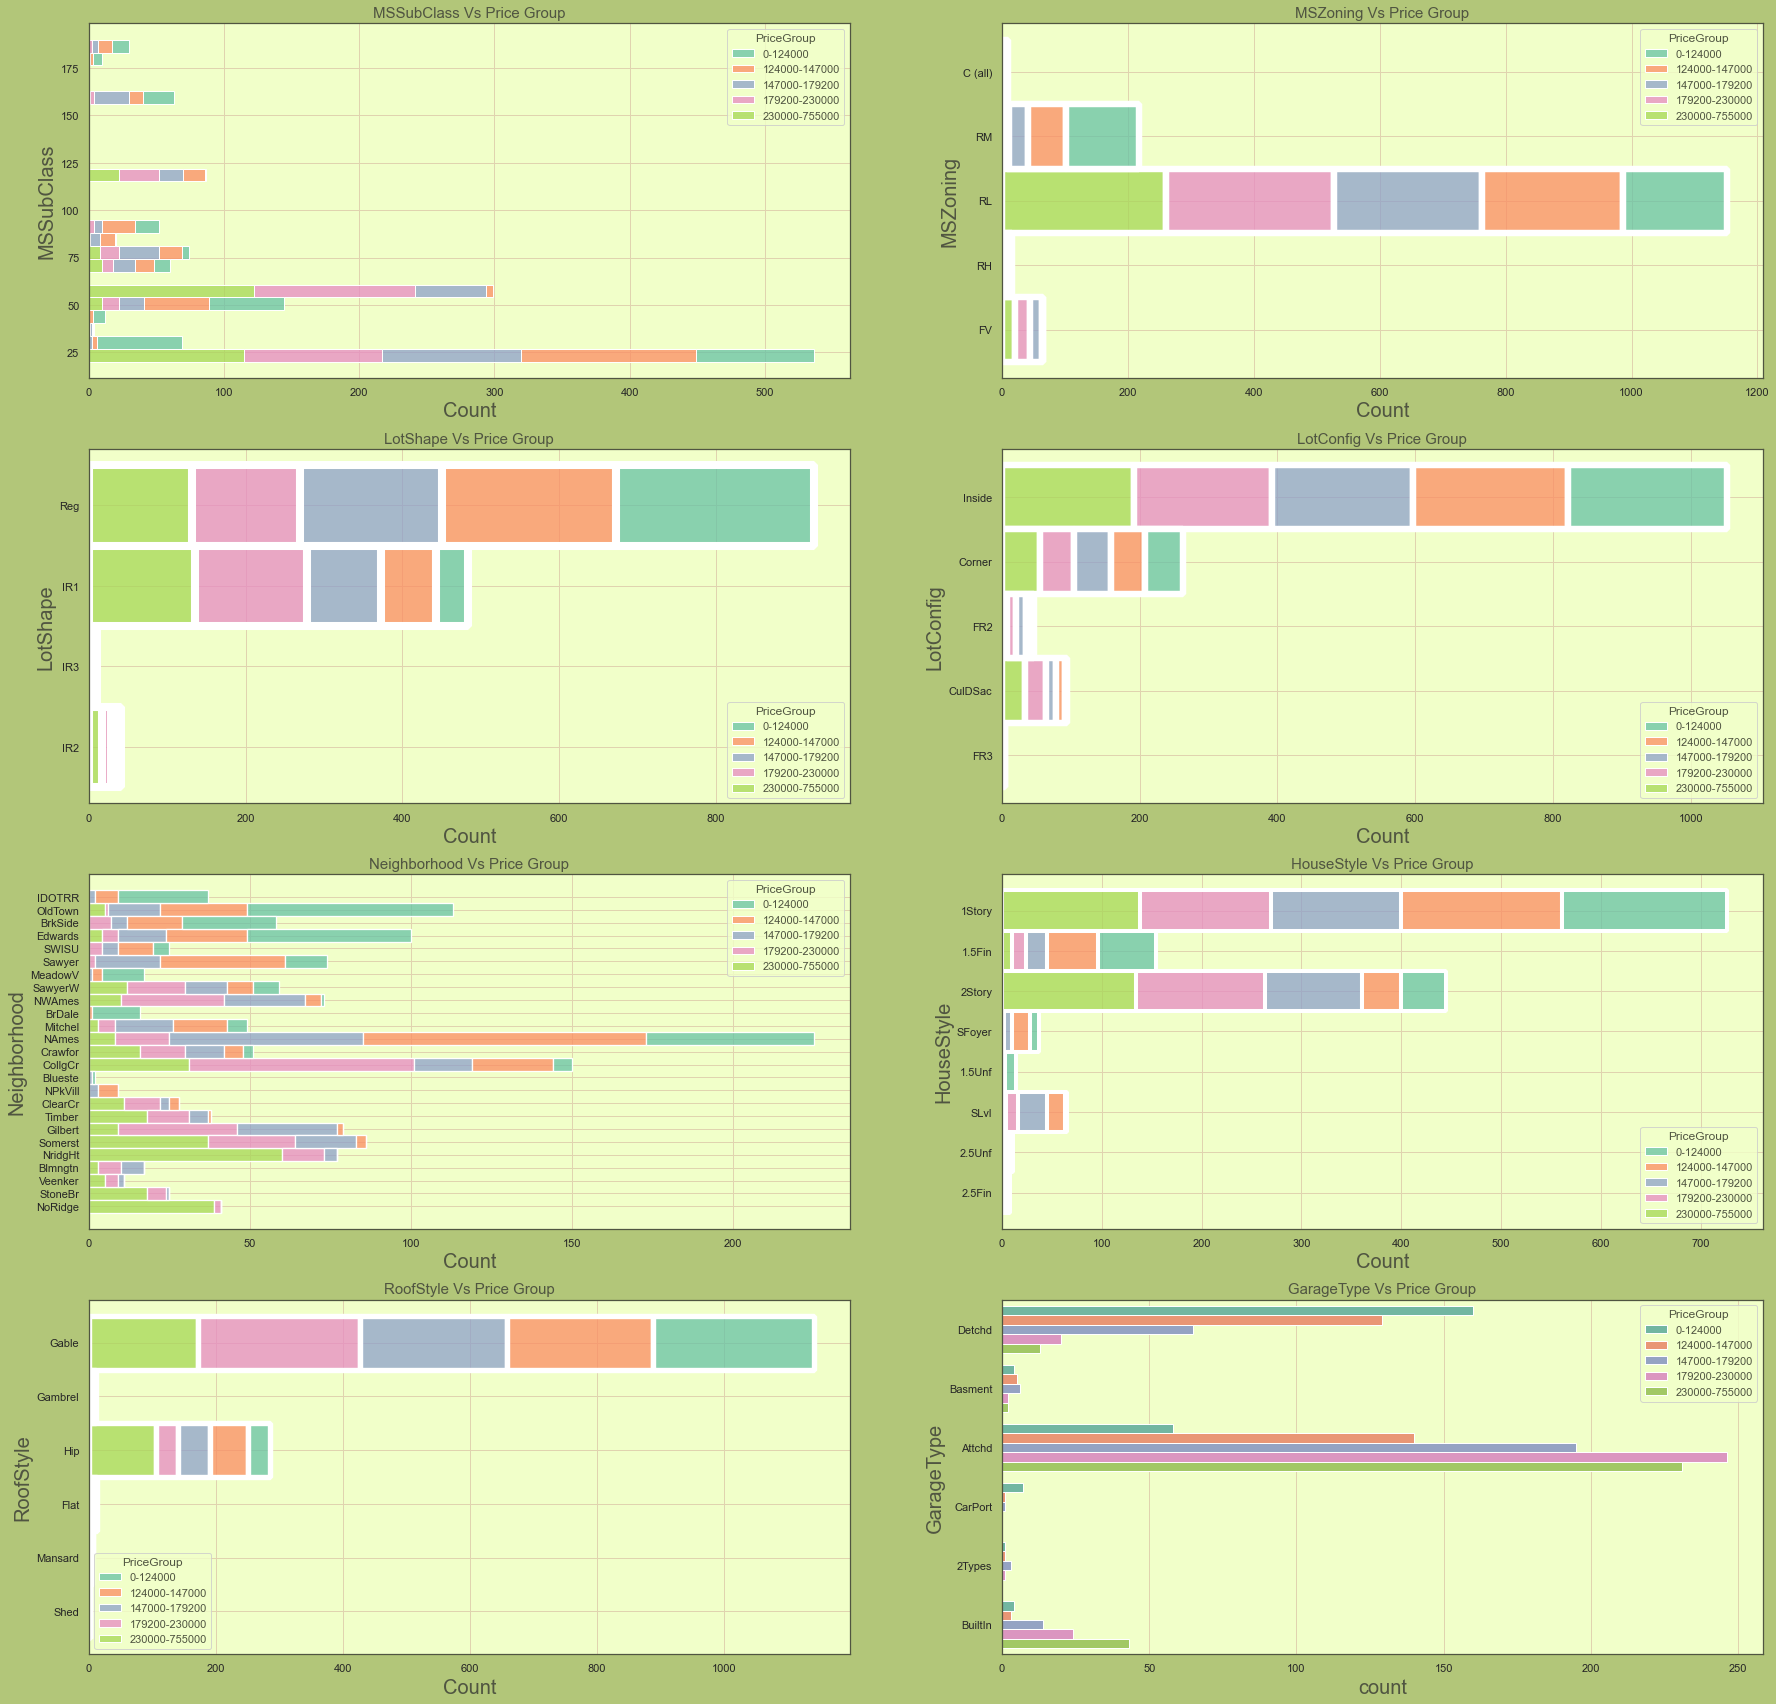

In [95]:
# sns.barplot(y='MSSubClass',hue='PriceGroup',data = visual_df, multiple="stack")
fig = plt.figure(figsize=(30,30))
gs = fig.add_gridspec(4,2)

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[1,0])
ax03 = fig.add_subplot(gs[1,1])
ax04 = fig.add_subplot(gs[2,0])
ax05 = fig.add_subplot(gs[2,1])
ax06 = fig.add_subplot(gs[3,0])
ax07 = fig.add_subplot(gs[3,1])

ax00.set_title('MSSubClass Vs Price Group', fontsize=15)
ax01.set_title('MSZoning Vs Price Group', fontsize=15)
ax02.set_title('LotShape Vs Price Group', fontsize=15)
ax03.set_title('LotConfig Vs Price Group', fontsize=15)
ax04.set_title('Neighborhood Vs Price Group', fontsize=15)
ax05.set_title('HouseStyle Vs Price Group', fontsize=15)
ax06.set_title('RoofStyle Vs Price Group', fontsize=15)
ax07.set_title('GarageType Vs Price Group', fontsize=15)

sns.histplot(data = visual_df,y="MSSubClass", kde=False, ax=ax00, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="MSZoning", kde=False, ax=ax01, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="LotShape", kde=False, ax=ax02, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="LotConfig", kde=False, ax=ax03, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="Neighborhood", kde=False, ax=ax04, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="HouseStyle", kde=False, ax=ax05, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.histplot(data = visual_df,y="RoofStyle", kde=False, ax=ax06, bins=25, palette="Set2", multiple="stack", hue="PriceGroup")
sns.countplot(data = visual_df,y="GarageType",palette="Set2",ax=ax07, hue="PriceGroup")

## Conclusion: 📝
1. As expected, the neighborhood appears to be significant.
2. LotConfig, RoofStyle and MSZoning have a very high single value weight and the other properties contain little information. We could exclude them or convert them to binary features like HasHipRoof or RMZonig.
3. GarageType looks interesting. We should convert this feature to a binary feature. Maybe AttachedGarage.
4. The same goes for Lot Shape and HouseStyle. Here we could add something like RegularShape (Yes/No) and HouseStyle -> (1Story, 2Story, other).
5. I think we can exclude MSSubClass. We can see some strong price correlations, e.g. in group 30, but I think the size of the single group is too small and could easily lead to overfitting.

# .
## 1.3.7 Other General Features:
Features Explanation:
1. LotFrontage: Linear feet of street connected to property
2. BsmtExposure: Walkout or garden level basement walls
3. Fireplaces: Number of fireplaces
4. EnclosedPorch: Enclosed porch area in square feet

In [96]:
other_general_features = ["LotFrontage", "BsmtExposure", "Fireplaces", "EnclosedPorch"]
info_df.loc[other_general_features]

,d_type,discret,percentage_of_missing_values,single_value_weight,min,max,mean,median,info_str
LotFrontage,float64,False,0.18,0.00,21.0,313.0,70.05,69.0,
BsmtExposure,object,True,0.03,0.65,0.0,0.0,0.00,0.0,"[953 X No, 221 X Av, 134 X Gd, 114 X Mn]"
Fireplaces,int64,True,0.00,0.47,0.0,0.0,0.00,0.0,"[690 X 0, 650 X 1, 115 X 2, 5 X 3]"
EnclosedPorch,int64,False,0.00,0.00,0.0,552.0,21.95,0.0,


In [97]:
other_general_features

['LotFrontage', 'BsmtExposure', 'Fireplaces', 'EnclosedPorch']

<AxesSubplot:title={'center':'EnclosedPorch Vs Price Group'}, xlabel='EnclosedPorch', ylabel='Count'>

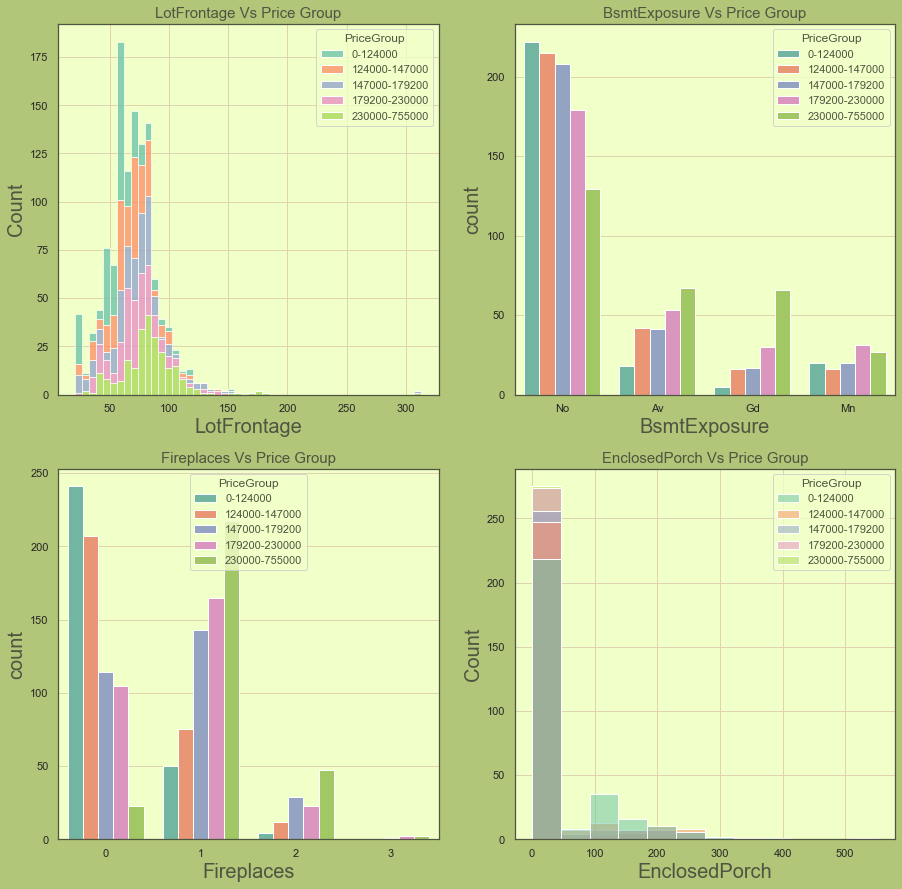

In [105]:
# sns.barplot(y='MSSubClass',hue='PriceGroup',data = visual_df, multiple="stack")
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(2,2)

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[1,0])
ax03 = fig.add_subplot(gs[1,1])


ax00.set_title('LotFrontage Vs Price Group', fontsize=15)
ax01.set_title('BsmtExposure Vs Price Group', fontsize=15)
ax02.set_title('Fireplaces Vs Price Group', fontsize=15)
ax03.set_title('EnclosedPorch Vs Price Group', fontsize=15)


sns.histplot(data = visual_df,x="LotFrontage", kde=False, ax=ax00, bins=50, palette="Set2", multiple="stack", hue="PriceGroup")
sns.countplot(data = visual_df,x="BsmtExposure", ax=ax01, palette="Set2", hue="PriceGroup")
sns.countplot(data = visual_df,x="Fireplaces", ax=ax02, palette="Set2", hue="PriceGroup")
sns.histplot(data = visual_df,x="EnclosedPorch", ax=ax03, palette="Set2", hue="PriceGroup")


## Conclusion: 📝
1. Lot Frontage looks good.
2. BsmtExposure and EnclosedPorch can be dropped. (Single value weight is too high)
3. Fireplaces should be transformt in HasFireplace (True,False)

## 1.3.8 General Plots:
We could expand on this inspection, but for now we'll wrap up this section with some general plotting and move on to some preprossesing.

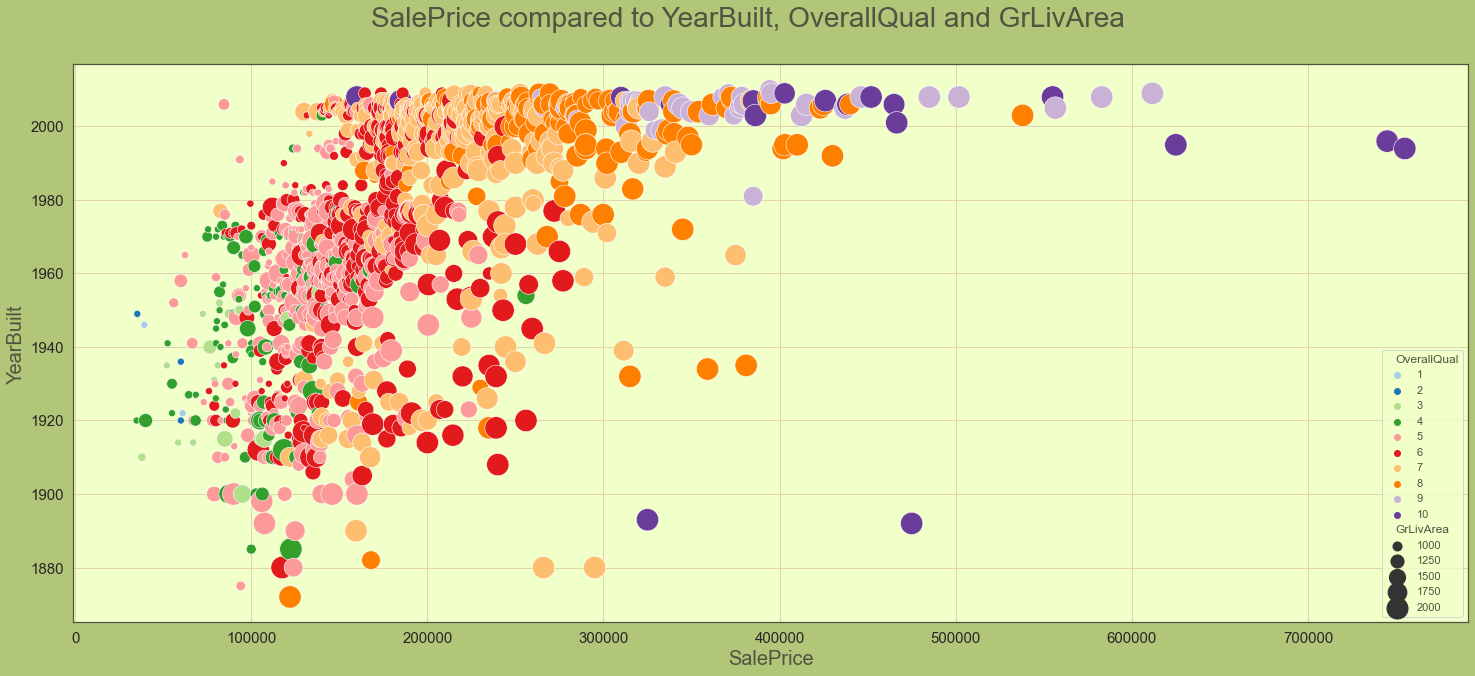

In [106]:
# build figure
f, ax = plt.subplots(figsize=(25, 10))
ax.tick_params(labelsize=15)
sns.scatterplot(data=visual_df, x="SalePrice", y="YearBuilt", hue="OverallQual", sizes=(50, 500), size="GrLivArea", palette="Paired")
f.subplots_adjust(top=0.9)
f.suptitle('SalePrice compared to YearBuilt, OverallQual and GrLivArea', fontsize="28");

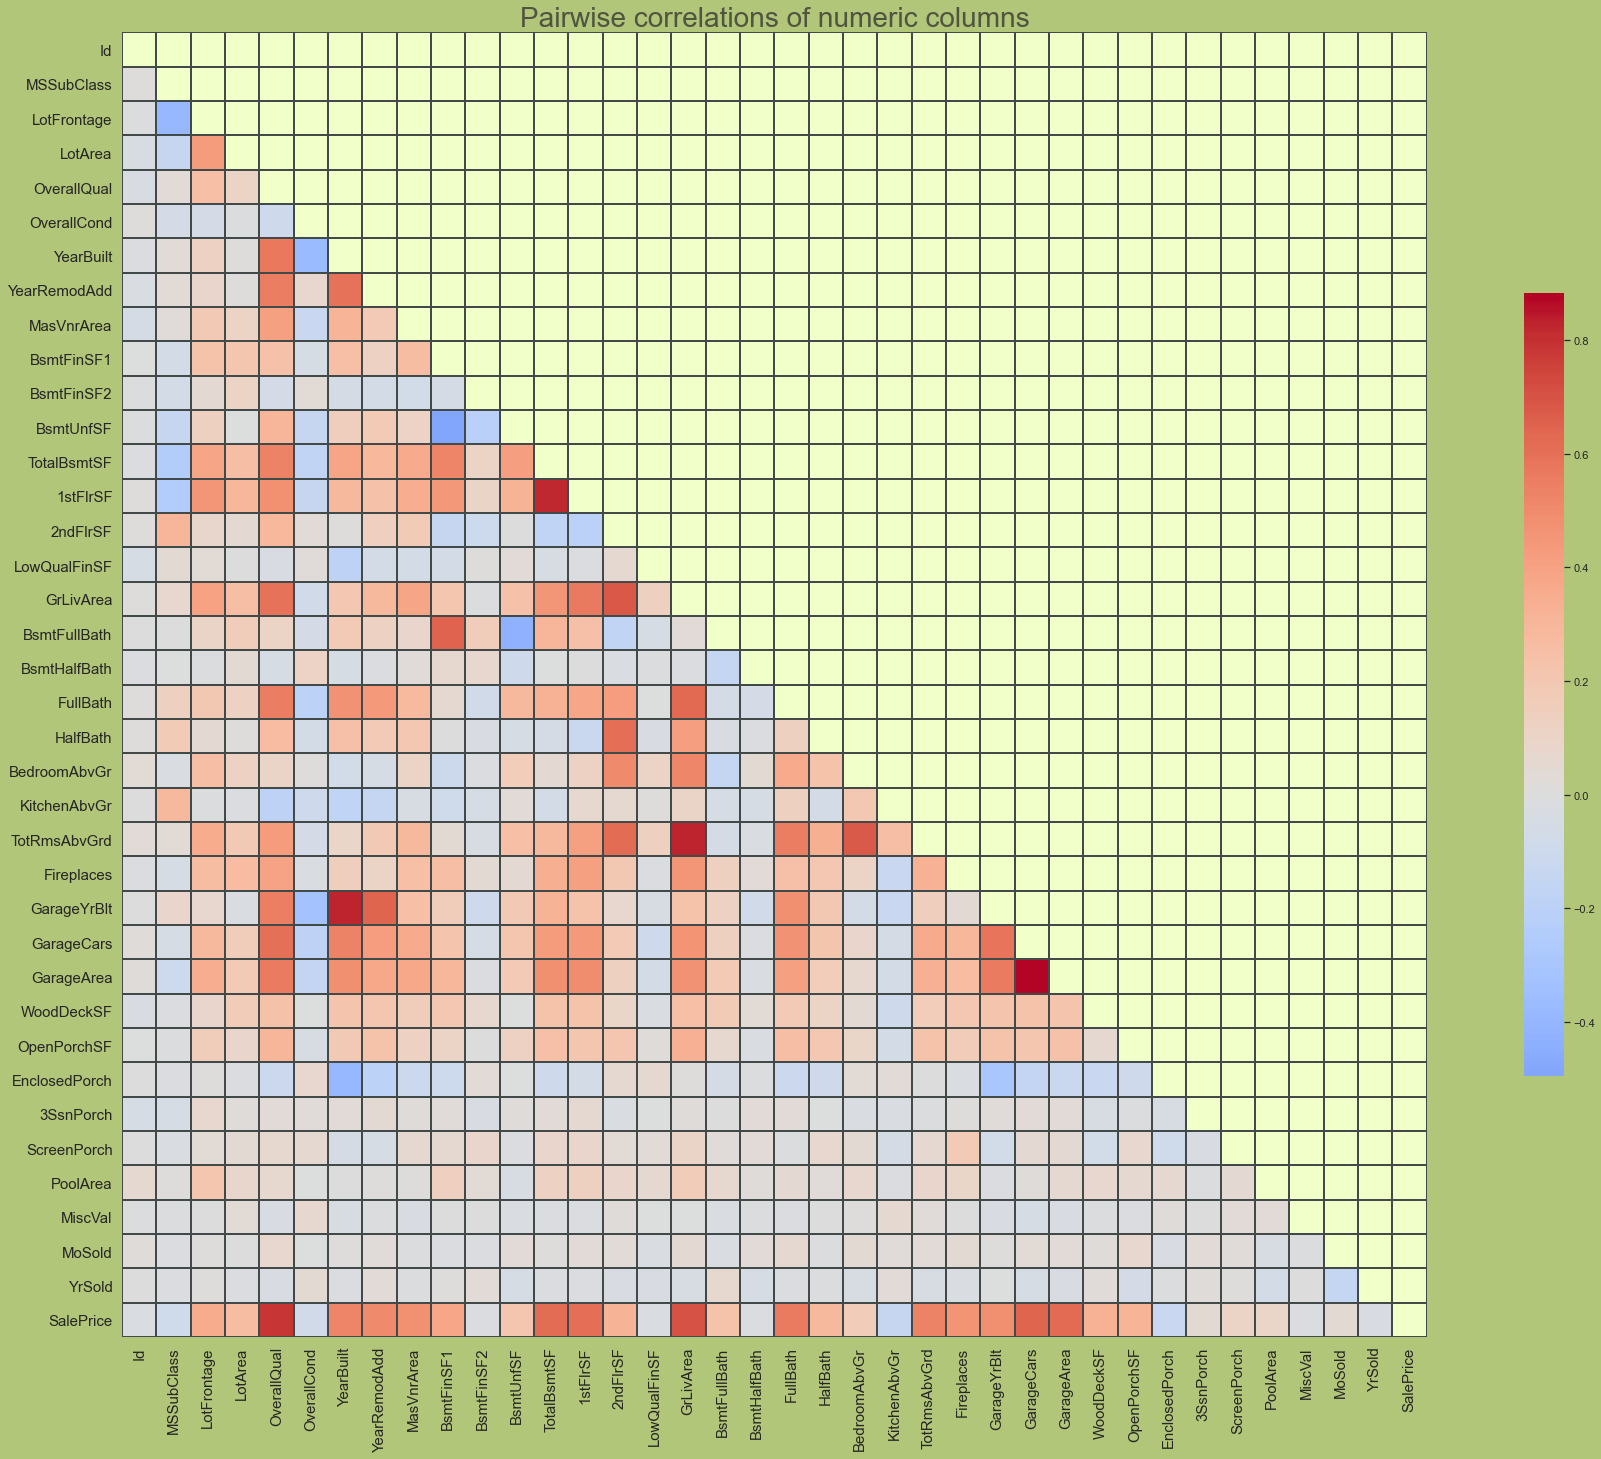

In [107]:
# claculate correlations:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(35, 24))
ax.tick_params(axis='both', which='major', labelsize=15)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=1, linecolor="#424949", annot=False, 
                cbar_kws={"shrink": 0.6}).set_title('Pairwise correlations of numeric columns', fontsize="28");

# .
# .
# .
# 📜🧾📊 --> 2. Data Preparation --> 📄


## 2.1 Cleaning Functions 🧹📃

In [108]:
def copy_df(df):
    copy_of_df = df.copy()
    return copy_of_df

# drop all columns with more then x % of single value weigth 
def drop_single_value_weight_cols(df, weight, info_df=info_df):
    cols = info_df[(info_df["discret"]==True)
                   & (info_df["single_value_weight"]>weight)].index
    cols = [c for c in cols if c in df.columns]
    print(f"dropped {', '.join(cols)} due to to much single value weight")
    df.drop(columns=cols, inplace=True)
    return df

# drop all columns with more then x% missing values
def drop_missing_value_cols(df, missing_ratio, info_df=info_df):
    cols = info_df[info_df["percentage_of_missing_values"]>missing_ratio].index
    cols = [c for c in cols if c in df.columns]
    print(f"dropped {', '.join(cols)} due to to much missing values")
    df.drop(columns=cols, inplace=True)
    return df

# fill missing values
def fill_missing_values(df,info_df=info_df):
    for col in df.columns:
        if info_df.loc[col]["discret"]:
            # discret columne
            # get the most frequent value (we should think of a better logic later on)
            most_frequent_value = train_df[col].value_counts().index[0]
            num_missing = df[col].isnull().sum()
            if num_missing > 0:
                print(f"filling {num_missing} missing values in {col} with {most_frequent_value}...")
                df[col].fillna(most_frequent_value, inplace=True)
        else:
            # continuous columne
            num_missing = df[col].isnull().sum()
            if num_missing > 0:
                print(f"filling {num_missing} missing values in {col} with mean...")
                df[col].fillna(df[col].mean(), inplace=True)
    return df

# first pipeline
def cleaning(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.5):
    print(50*"*")
    print("running cleaning...")
    piped_df =(df
              .pipe(copy_df)
              .pipe(drop_single_value_weight_cols, single_value_weigt)
              .pipe(drop_missing_value_cols, missing_value_weight)
              .pipe(fill_missing_values))
    print("done.")
    print(50*"*")
    return piped_df



In [109]:
cleaned_df = cleaning(train_df)
cleaned_df.head()

**************************************************
running cleaning...
dropped Street, LandContour, Utilities, LandSlope, Condition1, Condition2, BldgType, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, Functional, GarageQual, GarageCond, PavedDrive, 3SsnPorch, PoolArea, MiscVal, SaleType, SaleCondition due to to much single value weight
dropped Alley, PoolQC, Fence, MiscFeature due to to much missing values
filling 259 missing values in LotFrontage with mean...
filling 8 missing values in MasVnrType with None...
filling 8 missing values in MasVnrArea with mean...
filling 37 missing values in BsmtQual with TA...
filling 38 missing values in BsmtExposure with No...
filling 37 missing values in BsmtFinType1 with Unf...
filling 690 missing values in FireplaceQu with Gd...
filling 81 missing values in GarageType with Attchd...
filling 81 missing values in GarageYrBlt with mean...
filling 81 missing values in GarageFin

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,...,RFn,2,548,0,61,0,0,2,2008,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,...,RFn,2,460,298,0,0,0,5,2007,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,...,RFn,2,608,0,42,0,0,9,2008,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,...,Unf,3,642,0,35,272,0,2,2006,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,...,RFn,3,836,192,84,0,0,12,2008,250000


In [110]:
print(f"We are down to {len(cleaned_df.columns)} columns!")

We are down to 51 columns!


# 2.3 Pipeline Functions 📃➡🏭

Let's continue with some pipeline functions.

In [111]:
"""
We omit columns with low correlations to SalePrice for the first runs:
"""
def get_list_of_low_corr_coluns(df):
    corr_df = df.corr()
    columns = corr_df[abs(corr_df["SalePrice"])<0.1]["SalePrice"].index
    columns = [c for c in columns if c in df.columns]
    return list(columns)

def drop_columns(df, columns):
    columns = [c for c in columns if c in df.columns]
    print(f"dropping {', '.join(columns)}...")
    df.drop(columns=columns, inplace=True)
    return df

def get_list_of_numeric_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    return [c for c in df.select_dtypes(include=numerics).columns if c in df.columns]

# norming might not be appropriate for all numeric features. But its fine for now.
def norm_columns(df, columns):
    columns = [c for c in columns if c in df.columns]
    for col in columns:
        print(f"normalising {col}...")
        df[col] = (df[col]-df[col].mean())/df[col].std() 
    return df

def get_list_of_non_numeric_cat_cols(df, info_df=info_df):
    list_of_categorical_cols = list(info_df.loc[info_df["discret"]].index)
    list_of_categorical_cols = [c for c in list_of_categorical_cols if c in df.columns]
    list_of_numerical_cols = get_list_of_numeric_columns(df)
    return [c for c in list_of_categorical_cols if c not in list_of_numerical_cols]

def lable_encoding(df, columns):
    columns = [c for c in columns if c in df.columns]
    for col in columns:
        df[col]=df[col].astype('category').cat.codes
    return df

def drop_lable(df):
    if "SalePrice" in df.columns:
        print(f"dropping lable...")
        df.drop(columns="SalePrice", inplace=True)
    return df

"""
We start with lable coding because one hot encoding leads to a lot of columns and therefore training takes a long time.
"""
def pipeline(df, info_df=info_df):
    print(50*"#")
    print("running pipeline...")
    df = (df
          .pipe(cleaning)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(norm_columns, get_list_of_numeric_columns(df))
          .pipe(lable_encoding, get_list_of_non_numeric_cat_cols(df))
          .pipe(drop_lable)
         )
    print(50*"#")
    return df

## 2.4 Pipeline Functions Test

In [112]:
X = pipeline(train_df)
X.head()

##################################################
running pipeline...
**************************************************
running cleaning...
dropped Street, LandContour, Utilities, LandSlope, Condition1, Condition2, BldgType, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, Functional, GarageQual, GarageCond, PavedDrive, 3SsnPorch, PoolArea, MiscVal, SaleType, SaleCondition due to to much single value weight
dropped Alley, PoolQC, Fence, MiscFeature due to to much missing values
filling 259 missing values in LotFrontage with mean...
filling 8 missing values in MasVnrType with None...
filling 8 missing values in MasVnrArea with mean...
filling 37 missing values in BsmtQual with TA...
filling 38 missing values in BsmtExposure with No...
filling 37 missing values in BsmtFinType1 with Unf...
filling 690 missing values in FireplaceQu with Gd...
filling 81 missing values in GarageType with Attchd...
filling 81 missing va

,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,3,-0.229293,-0.207071,3,4,5,5,0.651256,1.050634,0.878367,...,2,1,1.020807,1,0.311618,0.350880,-0.751918,0.216429,-0.359202,-0.270116
1,3,0.451781,-0.091855,3,2,24,2,-0.071812,0.156680,-0.429430,...,4,1,-0.104447,1,0.311618,-0.060710,1.625638,-0.704242,-0.359202,-0.270116
2,3,-0.093078,0.073455,0,4,5,5,0.651256,0.984415,0.829930,...,4,1,0.937455,1,0.311618,0.631510,-0.751918,-0.070337,-0.359202,-0.270116
3,3,-0.456318,-0.096864,0,0,6,5,0.651256,-1.862993,-0.720051,...,2,5,0.812427,2,1.649742,0.790533,-0.751918,-0.175988,4.091122,-0.270116
4,3,0.633401,0.375020,0,2,15,5,1.374324,0.951306,0.733056,...,4,1,0.895779,1,1.649742,1.697903,0.779930,0.563567,-0.359202,-0.270116


### Running Model for Starting


In [113]:
"""
train split:
"""
y =  train_df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

xgb_model = xgb.XGBRegressor(subsample = 0.2, 
                             learning_rate=0.01,
                             max_depth=3, 
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:", xgb_model.score(X_train, y_train))
print("Performance on test data:", xgb_model.score(X_test, y_test))

Performance on train data: 0.9310325995978532
Performance on test data: 0.7459414025936518


## 4. Feature Engineering And Pipeline Extension 🤓🔧🏭

from chapter 1.3. We'll start with the date functions. We have "GarageYrBlt", "YearBuilt" and "YearRemodAdd". Let's combine these three features into one and leave out the old ones.

In [114]:
pipeline_test_df = train_df.copy()

# combine date feature from champter 1.3.1
def combine_date_features(df):
    # adds YearSinceRemod Features and drops "GarageYrBlt", "YearBuilt", "YearRemodAdd", "YrSold" and "MoSold"
    print("combine date features...")
    df["YearsSinceRemode"] = df["YrSold"] - df["YearRemodAdd"]
    df.drop(columns=["GarageYrBlt", "YearBuilt", "YearRemodAdd", "YrSold", "MoSold"], inplace=True)
    print("done.")
    return df

In [115]:
# Cases where 1stFlrSF + 2ndFlrSF != "GrLivArea"
pipeline_test_df["1FlrSF_plus_2FlrSF"] = pipeline_test_df["1stFlrSF"] + pipeline_test_df["2ndFlrSF"]
len(pipeline_test_df[pipeline_test_df["1FlrSF_plus_2FlrSF"] != pipeline_test_df["GrLivArea"]])

26

These 26 cases are ignored and only the total information is used. MasVnrArea is also ignored because the distribution is not really promising. I'm not entirely sure if it makes sense to drop BsmtFinSF1 and BsmtUnfSF, but I think that the needed information is contained in TotalBsmtSF and dropping these two features could prevent some overfitting.

In [116]:
# combine size feature from champter 1.3.2
def combine_size_features(df):
    # drop "BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "WoodDeckSF", "OpenPorchSF", "GarageArea" and ScreenPorch
    # add 2ndFloor feature
    print("combine size features...")
    df["2ndFloor"] = df["2ndFlrSF"].map(lambda x : "2ndFloor_True" if (x > 0) else "2ndFloor_False")
    df.drop(columns=["BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "WoodDeckSF", "OpenPorchSF", "GarageArea", "ScreenPorch"], inplace=True)
    print("done.")
    return df

# combine room_features from 1.3.3
def combine_room_features(df):
    # add feature IncludesBsmtBathroom
    # combine FullBath and HalfBath to new feature Bath
    # drom BsmtFullBath, BsmtHalfBath, FullBath, HalfBath and KitchenAbvGr
    print("combine room features...")
    df["Bath"] = df["FullBath"] + 1/2 * df["HalfBath"]
    df["IncludesBsmtFullBath"] = df["BsmtFullBath"].map(lambda x : "BsmtFullBath_True" if (x > 0) else "BsmtFullBath_False")
    df.drop(columns=["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "KitchenAbvGr"], inplace=True)
    print("done.")
    return df

# combine condition ad quality features from 1.3.4
def clean_qual_and_con_features(df):
    # drop OverallCond (looked a little skewed)
    # drop ExterQual, BsmtQual, KitchenQual, HeatingQC and FireplaceQu (little information and covered in OverallQuality)
    print("clear qual and con features...")
    df.drop(columns=["OverallCond", "ExterQual", "BsmtQual", "KitchenQual", "FireplaceQu", "HeatingQC"], inplace=True)
    print("done.")
    return df

In [117]:
# materiel features:
# drop  MasVnrType and Exterior2nd (mostly included in Exterior1st)
# cast Foundation down to 3 different types
# cast BsmtFinType1 and Exterior1st down to 4 different types

display(HTML(info_df.loc[["Foundation", "BsmtFinType1", "Exterior1st"]][["discret", "info_str"]].to_html()))
#info_df.loc[["Foundation", "BsmtFinType1", "Exterior1st"]]["info_str"]

,discret,info_str
Foundation,True,"[647 X PConc, 634 X CBlock, 146 X BrkTil, 24 X Slab, 6 X Stone, 3 X Wood]"
BsmtFinType1,True,"[430 X Unf, 418 X GLQ, 220 X ALQ, 148 X BLQ, 133 X Rec, 74 X LwQ]"
Exterior1st,True,"[515 X VinylSd, 222 X HdBoard, 220 X MetalSd, 206 X Wd Sdng, 108 X Plywood, 61 X CemntBd, 50 X BrkFace, 26 X WdShing, 25 X Stucco, 20 X AsbShng, 2 X BrkComm, 2 X Stone, 1 X ImStucc, 1 X AsphShn, 1 X CBlock]"


In [118]:
# combine material features from 1.3.5
def transform_material_features(df):
    print("transformin material features...")
    foundation_lables = ["PConc", "CBlock"]
    bsmt_fin_lables = ["Unf", "GLQ", "ALQ"]
    exterior1st_lables = ["VinylSB", "HdBoard", "MetalSd", "Wd Sdng"]
    def get_lable(val, list_of_lables, remaining_class):
        if val in list_of_lables:
            return val
        else:
            return remaining_class
    # cast down 
    df["Foundation"] = df["Foundation"].map(lambda x: get_lable(x, foundation_lables, "FBlock"))
    df["BsmtFinType1"] = df["BsmtFinType1"].map(lambda x: get_lable(x, bsmt_fin_lables, "FLQ"))
    df["Exterior1st"] = df["Exterior1st"].map(lambda x: get_lable(x, exterior1st_lables, "FBoard"))
    # drop 
    df.drop(columns=["MasVnrType", "Exterior2nd"], inplace=True)
    print("done.")
    return df

# handle other categorical features from 1.3.6
def transform_other_cat_features(df):
    # exclude LotConfig, RoofStyle, MSZoning and MSSubClass
    # transform GarageType
    # transform LotShape
    # transform HouseStyle
    print("transforming other material features...")
    def get_house_lable(val):
        if val in ["1Story", "2Story"]:
            return val
        else:
            return "otherStory"
    df["AttachedGarage"] = df["GarageType"].map(lambda x : "AttachedGarage_True" if (x=="Attchd" or x=="BuiltIn") else "AttachedGarage_False")
    df["RegLotShape"] = df["LotShape"].map(lambda x : "RegLotShape_True" if (x=="Reg") else "RegLotShape_False")
    df["HouseStyle"] = df["HouseStyle"].map(lambda x: get_house_lable(x))
    df.drop(columns=["LotConfig", "RoofStyle", "MSZoning", "MSSubClass", "GarageType", "LotShape"], inplace=True)
    print("done.")
    return df

# handle other general features from 1.3.7
def handle_other_general_features(df):
    # drop BsmtExposure and EnclosedPorch
    # transform Fireplaces to has fireplace
    print("handle other general features...")
    df["HasFireplace"] = df["Fireplaces"].map(lambda x : "Fireplaces_True" if (x>0) else "Fireplaces_False")
    df.drop(columns=["BsmtExposure", "EnclosedPorch", "Fireplaces"], inplace=True)
    print("done.")
    return df

## 4.1 Test Additional Features And New Pipeline Functions 👀🔎🏭

In [119]:
pipeline_test_df = (train_df
          .pipe(copy_df)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
         )
pipeline_test_df[["HouseStyle", "RegLotShape", "AttachedGarage", "Exterior1st", "BsmtFinType1", "Foundation", "IncludesBsmtFullBath", "Bath", "2ndFloor", "YearsSinceRemode"]].head()

combine size features...
done.
combine date features...
done.
combine room features...
done.
clear qual and con features...
done.
transformin material features...
done.
transforming other material features...
done.
handle other general features...
done.


,HouseStyle,RegLotShape,AttachedGarage,Exterior1st,BsmtFinType1,Foundation,IncludesBsmtFullBath,Bath,2ndFloor,YearsSinceRemode
0,2Story,RegLotShape_True,AttachedGarage_True,FBoard,GLQ,PConc,BsmtFullBath_True,2.5,2ndFloor_True,5
1,1Story,RegLotShape_True,AttachedGarage_True,MetalSd,ALQ,CBlock,BsmtFullBath_False,2.0,2ndFloor_False,31
2,2Story,RegLotShape_False,AttachedGarage_True,FBoard,GLQ,PConc,BsmtFullBath_True,2.5,2ndFloor_True,6
3,2Story,RegLotShape_False,AttachedGarage_False,Wd Sdng,ALQ,FBlock,BsmtFullBath_True,1.0,2ndFloor_True,36
4,2Story,RegLotShape_False,AttachedGarage_True,FBoard,GLQ,PConc,BsmtFullBath_True,2.5,2ndFloor_True,8


In [120]:
pipeline_test_df = (test_df
          .pipe(copy_df)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
         )
pipeline_test_df[["HouseStyle", "RegLotShape", "AttachedGarage", "Exterior1st", "BsmtFinType1", "Foundation", "IncludesBsmtFullBath", "Bath", "2ndFloor", "YearsSinceRemode"]].head()

combine size features...
done.
combine date features...
done.
combine room features...
done.
clear qual and con features...
done.
transformin material features...
done.
transforming other material features...
done.
handle other general features...
done.


,HouseStyle,RegLotShape,AttachedGarage,Exterior1st,BsmtFinType1,Foundation,IncludesBsmtFullBath,Bath,2ndFloor,YearsSinceRemode
0,1Story,RegLotShape_True,AttachedGarage_True,FBoard,FLQ,CBlock,BsmtFullBath_False,1.0,2ndFloor_False,49
1,1Story,RegLotShape_False,AttachedGarage_True,Wd Sdng,ALQ,CBlock,BsmtFullBath_False,1.5,2ndFloor_False,52
2,2Story,RegLotShape_False,AttachedGarage_True,FBoard,GLQ,PConc,BsmtFullBath_False,2.5,2ndFloor_True,12
3,2Story,RegLotShape_False,AttachedGarage_True,FBoard,GLQ,PConc,BsmtFullBath_False,2.5,2ndFloor_True,12
4,1Story,RegLotShape_False,AttachedGarage_True,HdBoard,ALQ,PConc,BsmtFullBath_False,2.0,2ndFloor_False,18


## 4.2 New Pipeline 🎇🏭✨

In [121]:
def advanced_pipeline(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.6):
    print(50*"#")
    print("running advanced pipeline...")
    df = (df
          .pipe(copy_df)
          .pipe(fill_missing_values)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
          .pipe(drop_single_value_weight_cols, single_value_weigt)
          .pipe(drop_missing_value_cols, missing_value_weight)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(drop_lable)
         )
    print(50*"#")
    return df
piped_df = advanced_pipeline(train_df)

##################################################
running advanced pipeline...
filling 259 missing values in LotFrontage with mean...
filling 1369 missing values in Alley with Grvl...
filling 8 missing values in MasVnrType with None...
filling 8 missing values in MasVnrArea with mean...
filling 37 missing values in BsmtQual with TA...
filling 37 missing values in BsmtCond with TA...
filling 38 missing values in BsmtExposure with No...
filling 37 missing values in BsmtFinType1 with Unf...
filling 38 missing values in BsmtFinType2 with Unf...
filling 1 missing values in Electrical with SBrkr...
filling 690 missing values in FireplaceQu with Gd...
filling 81 missing values in GarageType with Attchd...
filling 81 missing values in GarageYrBlt with mean...
filling 81 missing values in GarageFinish with Unf...
filling 81 missing values in GarageQual with TA...
filling 81 missing values in GarageCond with TA...
filling 1453 missing values in PoolQC with Gd...
filling 1179 missing values in F

In [122]:
print(f"We are done to {len(piped_df.columns)} features!")

We are done to 21 features!


In [123]:
display(HTML(piped_df.head().to_html()))

,LotFrontage,LotArea,Neighborhood,HouseStyle,OverallQual,Exterior1st,Foundation,BsmtFinType1,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,GarageFinish,GarageCars,2ndFloor,YearsSinceRemode,Bath,IncludesBsmtFullBath,AttachedGarage,RegLotShape,HasFireplace
0,65.0,8450,CollgCr,2Story,7,FBoard,PConc,GLQ,856,1710,3,8,RFn,2,2ndFloor_True,5,2.5,BsmtFullBath_True,AttachedGarage_True,RegLotShape_True,Fireplaces_False
1,80.0,9600,Veenker,1Story,6,MetalSd,CBlock,ALQ,1262,1262,3,6,RFn,2,2ndFloor_False,31,2.0,BsmtFullBath_False,AttachedGarage_True,RegLotShape_True,Fireplaces_True
2,68.0,11250,CollgCr,2Story,7,FBoard,PConc,GLQ,920,1786,3,6,RFn,2,2ndFloor_True,6,2.5,BsmtFullBath_True,AttachedGarage_True,RegLotShape_False,Fireplaces_True
3,60.0,9550,Crawfor,2Story,7,Wd Sdng,FBlock,ALQ,756,1717,3,7,Unf,3,2ndFloor_True,36,1.0,BsmtFullBath_True,AttachedGarage_False,RegLotShape_False,Fireplaces_True
4,84.0,14260,NoRidge,2Story,8,FBoard,PConc,GLQ,1145,2198,4,9,RFn,3,2ndFloor_True,8,2.5,BsmtFullBath_True,AttachedGarage_True,RegLotShape_False,Fireplaces_True


* We need to scale LotFront, LotArea, TotalBsmtSF, GrLiveArea, YearsSinceRemod, OverallQual, BedroomAbvGr, Bath and TotRmsAbvGrd. - MinMax scaling may not be the best method for all of them. We should truncate the outlires of LotFront, LotArea, TotalBsmtSF and GrLiveArea * The rest of the features can be processed with one hot encoding So let's write some functions for these last pipeline steps.

In [124]:
# one hot encoding implementation
def one_hot_encoding(df, columns):
    for col in columns:
        print(f"one hot encoding for {col}...")
        # Get one hot encoding of columns B
        one_hot_df = pd.get_dummies(df[col])
        # Drop input column as it is now encoded
        df = df.drop(col, axis=1)
        # add prefix to prevent overlapping values
        one_hot_df = one_hot_df.add_prefix(col + "_")
        # Join the encoded df
        df = df.join(one_hot_df)
    return df

# truncate function:
def truncate_upper_and_lower_quantile(df, columns, lower_quantile=0.1, upper_quantile=0.9):
    for col in columns:
        print(f"truncate {col}")
        u_quant = df[col].quantile(upper_quantile)
        l_quant = df[col].quantile(lower_quantile)
        df[col] = np.where(df[col]>u_quant, u_quant,df[col])
        df[col] = np.where(df[col]<l_quant, l_quant,df[col])
    return df

In [125]:
"""
Let's override our pipeline function:
"""
def advanced_pipeline(df, info_df=info_df, single_value_weigt=0.8, missing_value_weight=0.6):
    print(50*"#")
    print("running advanced pipeline...")
    df = (df
          .pipe(copy_df)
          .pipe(fill_missing_values)
          .pipe(combine_size_features)
          .pipe(combine_date_features)
          .pipe(combine_room_features)
          .pipe(clean_qual_and_con_features)
          .pipe(transform_material_features)
          .pipe(transform_other_cat_features)
          .pipe(handle_other_general_features)
          .pipe(drop_single_value_weight_cols, single_value_weigt)
          .pipe(drop_missing_value_cols, missing_value_weight)
          .pipe(drop_columns, get_list_of_low_corr_coluns(train_df))
          .pipe(one_hot_encoding, ["Neighborhood", "HouseStyle", "Exterior1st", "Foundation", "BsmtFinType1", "GarageFinish", "2ndFloor", "IncludesBsmtFullBath", "AttachedGarage", "RegLotShape", "HasFireplace"])
          .pipe(truncate_upper_and_lower_quantile, ["LotFrontage", "LotArea", "TotalBsmtSF", "GrLivArea"])
          .pipe(norm_columns, ["LotFrontage", "LotArea", "OverallQual", "TotalBsmtSF", "GrLivArea", "BedroomAbvGr", "TotRmsAbvGrd", "GarageCars", "YearsSinceRemode", "Bath"])
          .pipe(drop_lable)
         )
    print(50*"#")
    return df
piped_df = advanced_pipeline(train_df)

##################################################
running advanced pipeline...
filling 259 missing values in LotFrontage with mean...
filling 1369 missing values in Alley with Grvl...
filling 8 missing values in MasVnrType with None...
filling 8 missing values in MasVnrArea with mean...
filling 37 missing values in BsmtQual with TA...
filling 37 missing values in BsmtCond with TA...
filling 38 missing values in BsmtExposure with No...
filling 37 missing values in BsmtFinType1 with Unf...
filling 38 missing values in BsmtFinType2 with Unf...
filling 1 missing values in Electrical with SBrkr...
filling 690 missing values in FireplaceQu with Gd...
filling 81 missing values in GarageType with Attchd...
filling 81 missing values in GarageYrBlt with mean...
filling 81 missing values in GarageFinish with Unf...
filling 81 missing values in GarageQual with TA...
filling 81 missing values in GarageCond with TA...
filling 1453 missing values in PoolQC with Gd...
filling 1179 missing values in F

In [126]:
display(HTML(piped_df.head().to_html()))

,LotFrontage,LotArea,OverallQual,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,GarageCars,YearsSinceRemode,Bath,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_otherStory,Exterior1st_FBoard,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Foundation_CBlock,Foundation_FBlock,Foundation_PConc,BsmtFinType1_ALQ,BsmtFinType1_FLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,2ndFloor_2ndFloor_False,2ndFloor_2ndFloor_True,IncludesBsmtFullBath_BsmtFullBath_False,IncludesBsmtFullBath_BsmtFullBath_True,AttachedGarage_AttachedGarage_False,AttachedGarage_AttachedGarage_True,RegLotShape_RegLotShape_False,RegLotShape_RegLotShape_True,HasFireplace_Fireplaces_False,HasFireplace_Fireplaces_True
0,-0.336531,-0.400391,0.651256,-0.628362,0.570810,0.163723,0.911897,0.311618,-0.869643,1.168986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0
1,0.806297,0.003939,-0.071812,0.664890,-0.546692,0.163723,-0.318574,0.311618,0.390007,0.382842,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1
2,-0.107965,0.584063,0.651256,-0.424499,0.760386,0.163723,-0.318574,0.311618,-0.821195,1.168986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,1
3,-0.717473,-0.013641,0.651256,-0.946897,0.588271,0.163723,0.296662,1.649742,0.632247,-1.189447,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1
4,1.111051,1.642351,1.374324,0.292204,1.689059,1.389547,1.527133,1.649742,-0.724299,1.168986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,1


In [127]:
print(f"Number of columns: {len(piped_df.columns)}")

Number of columns: 62


# 5. Modeling Selection And Parameter Tuning 👀🔎📄

In [128]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from functools import partial
#from sklearn.metrics import mean_squared_error

y = train_df["SalePrice"]
X = advanced_pipeline(train_df)
qt = QuantileTransformer(random_state=0, output_distribution="normal")
y = y.values.reshape(-1, 1)
y = qt.fit_transform(y)
y = pd.Series(y[:, 0])

##################################################
running advanced pipeline...
filling 259 missing values in LotFrontage with mean...
filling 1369 missing values in Alley with Grvl...
filling 8 missing values in MasVnrType with None...
filling 8 missing values in MasVnrArea with mean...
filling 37 missing values in BsmtQual with TA...
filling 37 missing values in BsmtCond with TA...
filling 38 missing values in BsmtExposure with No...
filling 37 missing values in BsmtFinType1 with Unf...
filling 38 missing values in BsmtFinType2 with Unf...
filling 1 missing values in Electrical with SBrkr...
filling 690 missing values in FireplaceQu with Gd...
filling 81 missing values in GarageType with Attchd...
filling 81 missing values in GarageYrBlt with mean...
filling 81 missing values in GarageFinish with Unf...
filling 81 missing values in GarageQual with TA...
filling 81 missing values in GarageCond with TA...
filling 1453 missing values in PoolQC with Gd...
filling 1179 missing values in F

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [130]:
xgb_model = xgb.XGBRegressor(subsample=0.7, 
                             learning_rate=0.02,
                             max_depth=3, 
                             random_state=np.random.randint(1000),
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:", xgb_model.score(X_train, y_train))
print("Performance on test data:", xgb_model.score(X_test, y_test))

Performance on train data: 0.9369572350690335
Performance on test data: 0.8560268357289841


In [131]:
gb_model = GradientBoostingRegressor(subsample=0.7, 
                             learning_rate=0.02,
                             max_depth=3, 
                             random_state=np.random.randint(1000),
                             n_estimators=500).fit(X_train, y_train)
print("Performance on train data:", gb_model.score(X_train, y_train))
print("Performance on test data:", gb_model.score(X_test, y_test))

Performance on train data: 0.9417689378265869
Performance on test data: 0.8553335303336214


In [132]:
"""
Lets add a liner model:
"""
clf = linear_model.Lasso(alpha=0.5).fit(X_train, y_train)
print("Performance on train data:", clf.score(X_train, y_train))
print("Performance on test data:", clf.score(X_test, y_test))

Performance on train data: 0.4426093855179851
Performance on test data: 0.41416009108718843


## GradientBoost Regerssor is giving best accuracy